# Produisez une étude de marché : Clustering + ACP


[ Importation des librairies](#Importation-des-librairies)

[Définition des fonctions](#Definition-des-fonctions)

[Matrice de correlation](#Matrice-de-correlation)

[Suppression des outliers](#Supprime-les-outliers) 

[ACH](#ACH) 

[Kmeans](#K-means) 

[Boxplot](#Boxplot) 

[Radarchart](#Radar-chart) 

[ACP](#ACP) 

[3D viz](#3D) 


# Importation-des-librairies

In [1211]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import boxcox

from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler


from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score


from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.pipeline import make_pipeline


import plotly.express as px

from scipy.stats.mstats import winsorize
from sklearn.metrics import silhouette_samples, silhouette_score

pd.set_option('display.max_colwidth', None)

# Definition des fonctions

In [1212]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

 
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [1213]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="."):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

### On charge le dataframe traité en amont `data_p9`

In [1214]:
df = pd.read_csv('data_p9.csv')

In [1215]:
df = df.drop(columns=['Code zone'])
df.rename(columns = {'Zone_x': 'Pays'}, inplace = True) 


In [1216]:
df.head(5)

,Pays,pop_2017,TCAM,prixpoulet,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Exportations - Quantité,Importations - Quantité,Nourriture,TCAM_pib,Investment,Pib_hab17
0,Afghanistan,36296113.0,2.180893,2944.20,-2.70,5.0,5.333333,29.0,55.0,-1.185649,51.533897,520.616409
1,Afrique du Sud,57009756.0,1.163683,2015.10,-0.22,143.0,63.000000,514.0,2035.0,0.976433,2008.360978,6121.876572
2,Albanie,2884169.0,-0.093847,2469.70,0.36,85.0,0.000000,38.0,47.0,2.758801,1016.561053,4514.204908
3,Algérie,41389189.0,1.643155,2180.70,-0.99,22.0,0.000000,2.0,264.0,-3.881311,1232.341924,4109.696001
4,Allemagne,82658409.0,0.407719,1204.25,0.64,71.0,646.000000,842.0,1609.0,0.476242,33261.034105,44651.829102


In [1217]:
df.set_index(['Pays'], inplace=True) # defini comme index

### Supprime colonne exportations , prix poulet et TCAM de la population et TCAM_pib

In [1218]:
df = df.drop(columns=['Exportations - Quantité','prixpoulet','TCAM','TCAM_pib'])

> exportations pas d interet dans le cadre de notre etude, prix poulet ( pas assez de données fiable) 
Concernant les 2 autres variables, après plusieurs test, nous décidons de ne pas les retenir comme critères d evaluations de nos groupes

In [1219]:
df.head(5)

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17
Pays,,,,,,,
Afghanistan,36296113.0,-2.70,5.0,29.0,55.0,51.533897,520.616409
Afrique du Sud,57009756.0,-0.22,143.0,514.0,2035.0,2008.360978,6121.876572
Albanie,2884169.0,0.36,85.0,38.0,47.0,1016.561053,4514.204908
Algérie,41389189.0,-0.99,22.0,2.0,264.0,1232.341924,4109.696001
Allemagne,82658409.0,0.64,71.0,842.0,1609.0,33261.034105,44651.829102


# Matrice de correlation

In [1220]:
# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation avec une coloration en dégradé
corr_matrix.style.background_gradient(cmap='coolwarm')

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17
pop_2017,1.000000,-0.098297,-0.070650,0.150992,0.656902,0.424090,-0.045870
indexpolitic,-0.098297,1.000000,0.453003,0.101865,0.009934,0.142746,0.552558
Disponibilité alimentaire (Kcal/personne/jour),-0.070650,0.453003,1.000000,0.169243,0.214881,0.258305,0.379497
Importations - Quantité,0.150992,0.101865,0.169243,1.000000,0.261689,0.322184,0.261990
Nourriture,0.656902,0.009934,0.214881,0.261689,1.000000,0.797427,0.118216
Investment,0.424090,0.142746,0.258305,0.322184,0.797427,1.000000,0.345617
Pib_hab17,-0.045870,0.552558,0.379497,0.261990,0.118216,0.345617,1.000000


> Peut etre une Redondance d info avec `investisement étranger ` et `nourriture` mais nous decidons de quand meme garder ce critere car il nous semble pertinent

> L ACP étant sensible aux outliers, il est important de les identifier et ensuite de prendre une decision concernant leurs traitements


### Detection des outliers avec la  Matrice de Mahalanobis

In [1221]:

from scipy.stats import chi2


# calcul de la Matrice de Mahalanobis
M = df.values
M_centered = M - np.mean(M, axis=0)
cov_matrix = np.cov(M_centered, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mahalanobis_dist = []
for i in range(len(M)):
    dist = np.dot(np.dot(M_centered[i], inv_cov_matrix), M_centered[i].T)
    mahalanobis_dist.append(dist)
mahalanobis_dist = np.array(mahalanobis_dist)

# calcul de la valeur critique pour les outliers
p = len(df.columns) # nombre de variables
alpha = 0.01 # niveau de significativité
df_crit = chi2.ppf((1-alpha), p)
mahalanobis_crit = df_crit

# détection des outliers
outliers_mah = np.where(mahalanobis_dist > mahalanobis_crit)[0]
outliers_mah_df = df.iloc[outliers_mah]

In [1222]:
outliers_mah_df

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17
Pays,,,,,,,
Brésil,2.078338e+08,-0.400000,204.0,3.0,9982.0,58835.838821,9928.675992
Chine - RAS de Hong-Kong,7.306322e+06,0.850000,210.0,907.0,391.0,110685.529144,46705.027813
"Chine, continentale",1.421022e+09,0.796667,59.0,452.0,17518.0,136340.000000,8663.126784
Inde,1.338677e+09,-0.910000,7.0,0.0,2965.0,37366.000000,1960.390340
Israël,8.243848e+06,-0.920000,234.0,0.0,556.0,16893.000000,43096.069697
Japon,1.275027e+08,1.050000,67.0,1069.0,2359.0,9355.587239,38672.407740
Luxembourg,5.919100e+05,1.390000,69.0,11.0,11.0,-27368.646988,111017.182246
Mexique,1.247773e+08,-0.720000,123.0,972.0,4058.0,34130.864990,9287.841557
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,6.672746e+07,0.340000,120.0,779.0,2131.0,96378.285155,40448.365256


# Supprime les outliers

In [1223]:
#liste_valeur_ab = ['Chine, continentale', "États-Unis d'Amérique","Inde","Suisse",'Luxembourg','Brésil']
liste_valeur_ab = ['Chine, continentale',"Inde","États-Unis d'Amérique"]
df = df[~df.index.isin(liste_valeur_ab)]

> Nous supprimons seulement le gros outliers ( outliers sur plusieurs varibles)

In [1224]:
#df.set_index(['Pays'], inplace=True) # defini comme index

In [1225]:
df.shape

(169, 7)

In [1226]:
df

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17
Pays,,,,,,,
Afghanistan,36296113.0,-2.70,5.0,29.0,55.0,51.533897,520.616409
Afrique du Sud,57009756.0,-0.22,143.0,514.0,2035.0,2008.360978,6121.876572
Albanie,2884169.0,0.36,85.0,38.0,47.0,1016.561053,4514.204908
Algérie,41389189.0,-0.99,22.0,2.0,264.0,1232.341924,4109.696001
Allemagne,82658409.0,0.64,71.0,842.0,1609.0,33261.034105,44651.829102
...,...,...,...,...,...,...,...
Égypte,96442591.0,-1.38,50.0,110.0,1250.0,13163.100000,2023.331158
Émirats arabes unis,9487203.0,0.66,147.0,433.0,412.0,10354.223000,40644.804043
Équateur,16785361.0,-0.10,83.0,0.0,324.0,629.542412,6213.501276


In [1227]:
#On recupere le noms des pays dans la variable names
names = df.index

### On scale les données

In [1228]:
# On recupere les valeurs du df dans X
X=df.values

In [1229]:
scaler_standard = StandardScaler()   #RobustScaler()  #StandardScaler()
# On fit :

scaler_standard.fit(X)

# On transforme :

X_scaled = scaler_standard.transform(X)

# ACH

#### Nous allons calculer les distances en spécifiant la méthode à utiliser:

In [1230]:
Z = linkage(X_scaled, method="ward")
pd.DataFrame(Z)

,0,1,2,3
0,77.0,95.0,0.085409,2.0
1,27.0,162.0,0.104937,2.0
2,89.0,145.0,0.112152,2.0
3,108.0,129.0,0.118632,2.0
4,26.0,78.0,0.120822,2.0
...,...,...,...,...
163,324.0,326.0,11.355720,10.0
164,21.0,328.0,13.281021,16.0
165,327.0,333.0,16.716093,84.0
166,331.0,332.0,19.961320,85.0


#### Nous pouvons désormais afficher le dendrogramme:

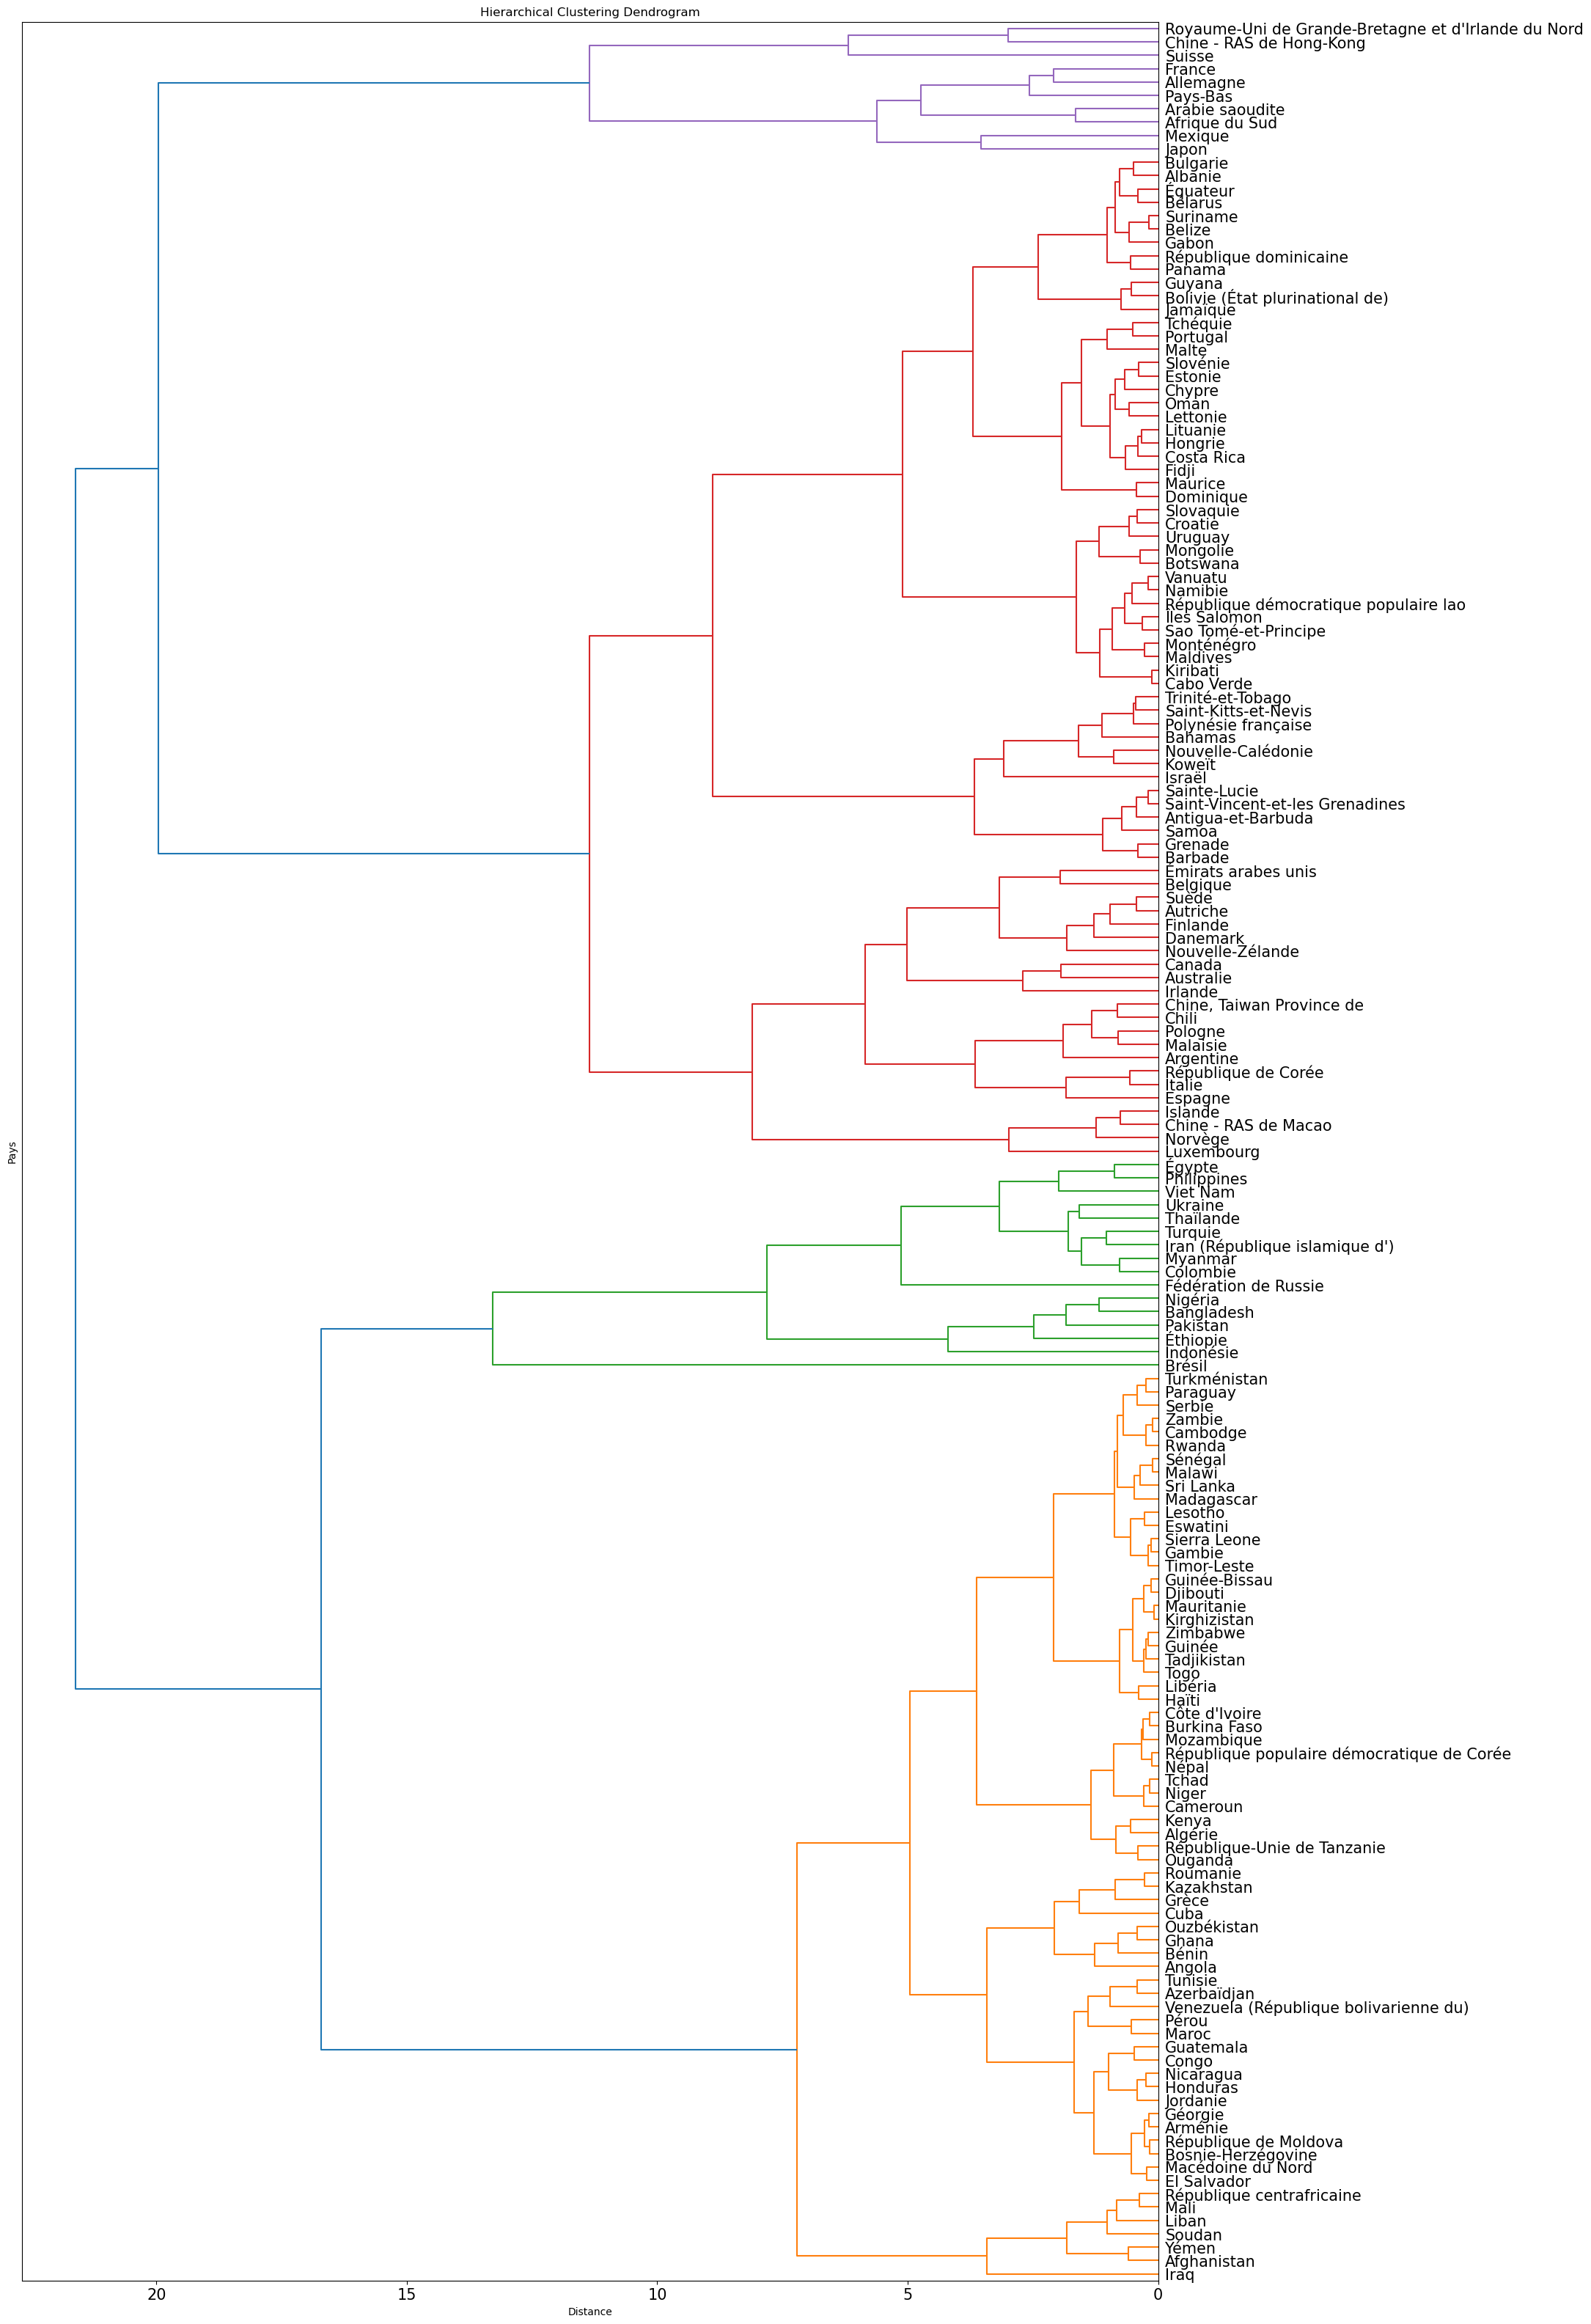

In [1231]:
fig, ax = plt.subplots(1, 1, figsize=(20,40))

_ = dendrogram(Z, ax=ax, labels=names, orientation = "left")

plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)


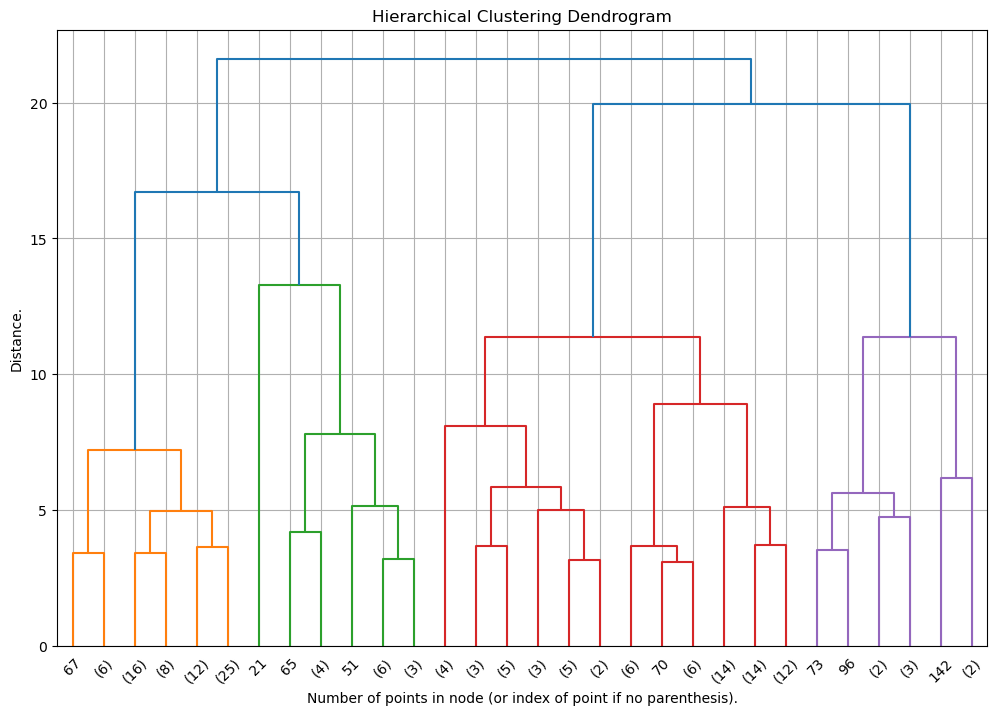

In [1232]:
# les arguments p=10, truncate_mode="lastp" signifient que l'on ne va afficher que 10 clusters

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, p=30, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.grid(True)
plt.show()

> Après lecture, nous décidons de creer 4 clusters

### Clusters

On instancie un estimateur :

In [1233]:
cah = AgglomerativeClustering(n_clusters=4, linkage="ward")

On entraine l'estimateur :

In [1234]:
cah.fit(X_scaled)

AgglomerativeClustering(n_clusters=4)

Regardons nos clusters :

In [1235]:
cah.labels_ # equivalent a cah.fit_predict(X_standard)

array([3, 1, 2, 3, 1, 3, 2, 1, 2, 3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 3, 2, 0,
       2, 3, 2, 3, 2, 3, 3, 2, 2, 1, 2, 2, 2, 0, 3, 2, 2, 3, 3, 2, 3, 2,
       3, 2, 2, 3, 2, 2, 1, 0, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0,
       0, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 1, 2, 2, 3, 0, 2, 3, 3, 0, 2, 2, 2, 3, 2,
       3, 3, 0, 2, 3, 1, 0, 2, 2, 2, 3, 3, 1, 3, 3, 2, 3, 2, 2, 3, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 2, 3, 3, 3, 2, 0, 3, 3, 2, 3,
       3, 0, 0, 2, 2, 3, 0, 3, 3, 3, 0, 2, 2, 0, 2])

### Test coefficient de silhouette / ( Affecté avec la Standardisation des données )

In [1236]:
# Calculer le coefficient de silhouette
silhouette_coeff = silhouette_score(X_scaled, cah.labels_)
silhouette_coeff
print("Coefficient de silhouette:", silhouette_coeff)

Coefficient de silhouette: 0.2707718042689694


Une valeur proche de 1 indique que l'observation est bien regroupée avec d'autres observations similaires dans son propre cluster et que les observations des autres clusters sont assez différentes.

### On reprend notre df et on cree une colonne avec les labels des clusters obtenus

In [1237]:
df["Clusterach"] = cah.labels_
df.head()

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17,Clusterach
Pays,,,,,,,,
Afghanistan,36296113.0,-2.70,5.0,29.0,55.0,51.533897,520.616409,3
Afrique du Sud,57009756.0,-0.22,143.0,514.0,2035.0,2008.360978,6121.876572,1
Albanie,2884169.0,0.36,85.0,38.0,47.0,1016.561053,4514.204908,2
Algérie,41389189.0,-0.99,22.0,2.0,264.0,1232.341924,4109.696001,3
Allemagne,82658409.0,0.64,71.0,842.0,1609.0,33261.034105,44651.829102,1


In [1238]:
# Créer un dictionnaire de correspondance étiquette-nom de cluster
cluster_names = {0: 'groupe 1', 1: 'groupe 2', 2: 'groupe 3', 3:'groupe 4',
                4: 'groupe 5', 5: 'groupe 6', 6: 'groupe 7', 7:'groupe 8',
                8: 'groupe 9', 9: 'groupe 10', 10: 'groupe 11', 11:'groupe 12',
                12: 'groupe 13', 13: 'groupe 14', 14: 'groupe 15', 15:'groupe 16'}

# Utiliser la méthode map() pour renommer les étiquettes de cluster
df['Clusterach'] = df['Clusterach'].map(cluster_names)

# K means

### elbow methode pour definir le nonre de clusters


In [1239]:
intertia = [] # defini une liste vide

In [1240]:
# On défini ensuite la liste du nombre de clusters que l'on veut tester:
k_list = range(1, 10)
list(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [1241]:
#Ensuite, pour chaque valeur de k, on entraine un k-means spécifique et on stocke son inertie :

for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_scaled) 
  intertia.append(kmeans.inertia_)

In [1242]:
# Nous obtenons une liste d'inerties :
intertia

[1183.0,
 895.5003351200762,
 690.742286185302,
 586.7525348287884,
 500.6496350722776,
 431.62731564618866,
 377.81691921900045,
 335.56427693786463,
 298.952036194641]

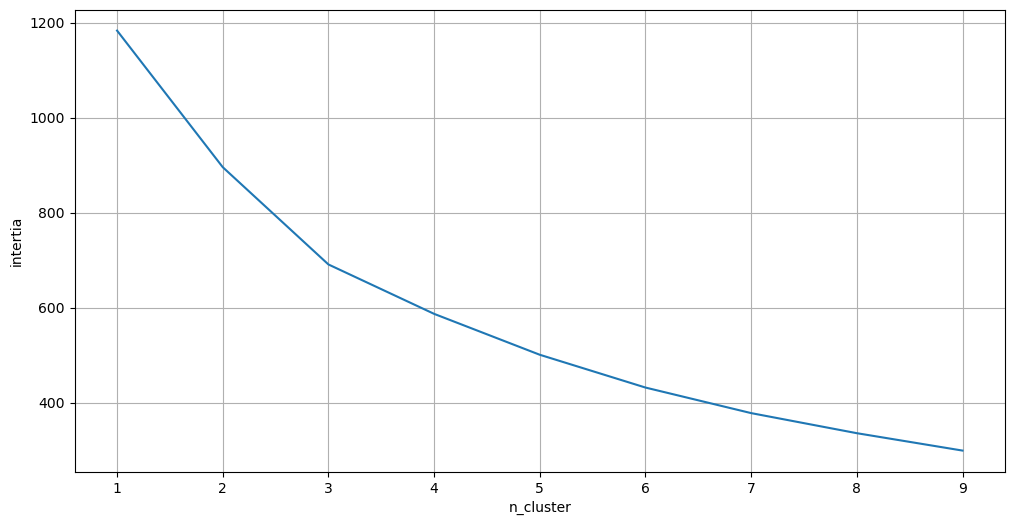

In [1243]:
# Il ne nous reste plus qu'à afficher le resultat :

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia)
plt.grid(True)
plt.show()

### Elbow sur données non standardisées

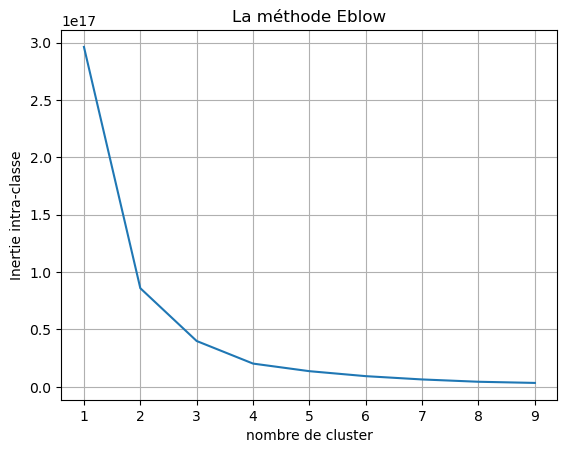

In [1244]:
#Détermination de la valeur optimale de K
tab=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    tab.append(kmeans.inertia_)
plt.plot(range(1,10),tab)
plt.title("La méthode Eblow")
plt.xlabel("nombre de cluster")
plt.ylabel("Inertie intra-classe")
plt.grid(True)
plt.show()

### Silhouette score

For n_clusters = 2 The average silhouette_score is : 0.5270799394163689
For n_clusters = 3 The average silhouette_score is : 0.3037157005215414
For n_clusters = 4 The average silhouette_score is : 0.3316689296497603
For n_clusters = 5 The average silhouette_score is : 0.3332633041966511
For n_clusters = 6 The average silhouette_score is : 0.31616689976548873
For n_clusters = 7 The average silhouette_score is : 0.32357201785206047
For n_clusters = 8 The average silhouette_score is : 0.2617226448806611
For n_clusters = 9 The average silhouette_score is : 0.26960550747816314
For n_clusters = 10 The average silhouette_score is : 0.2851721734776194


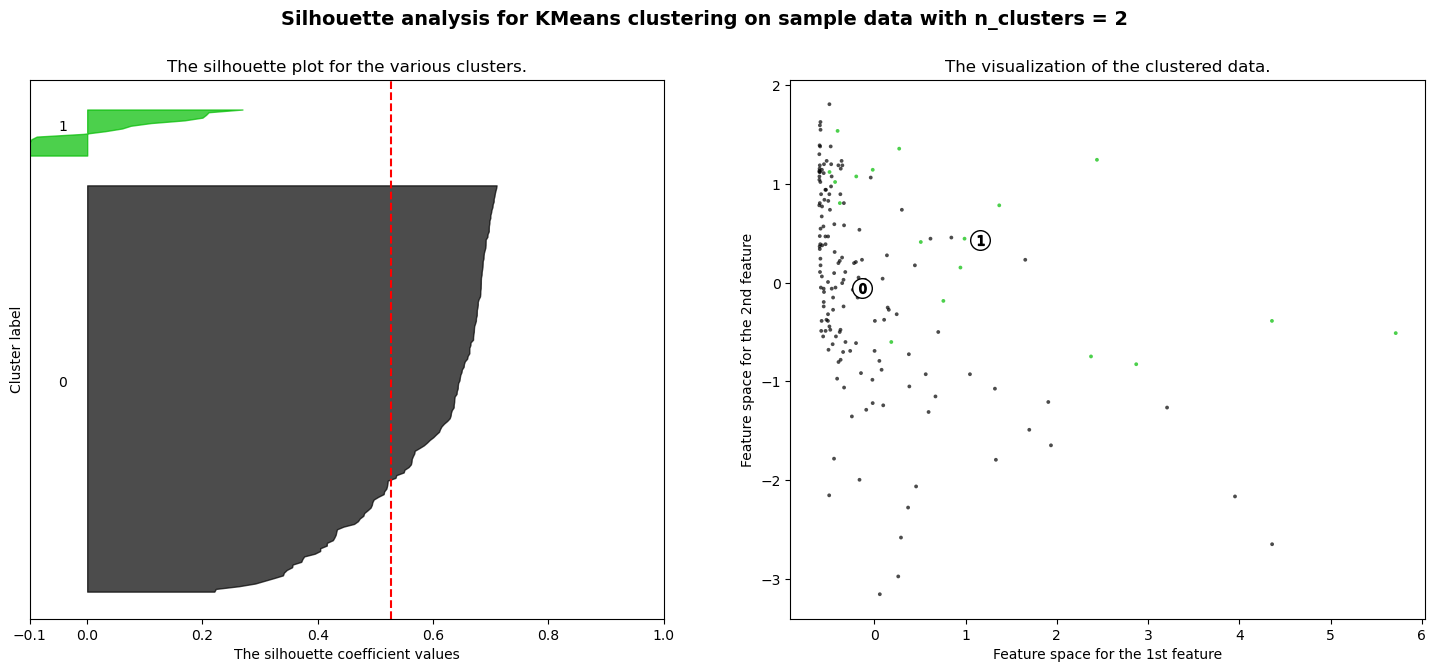

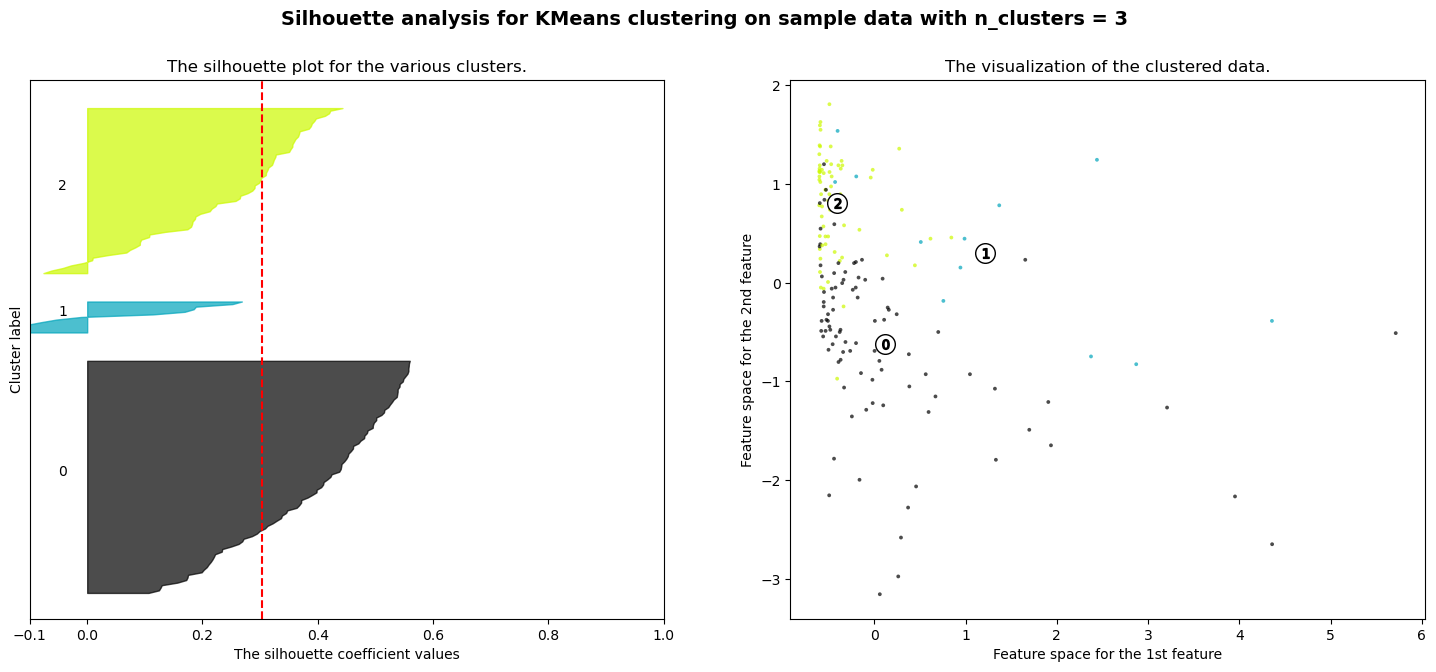

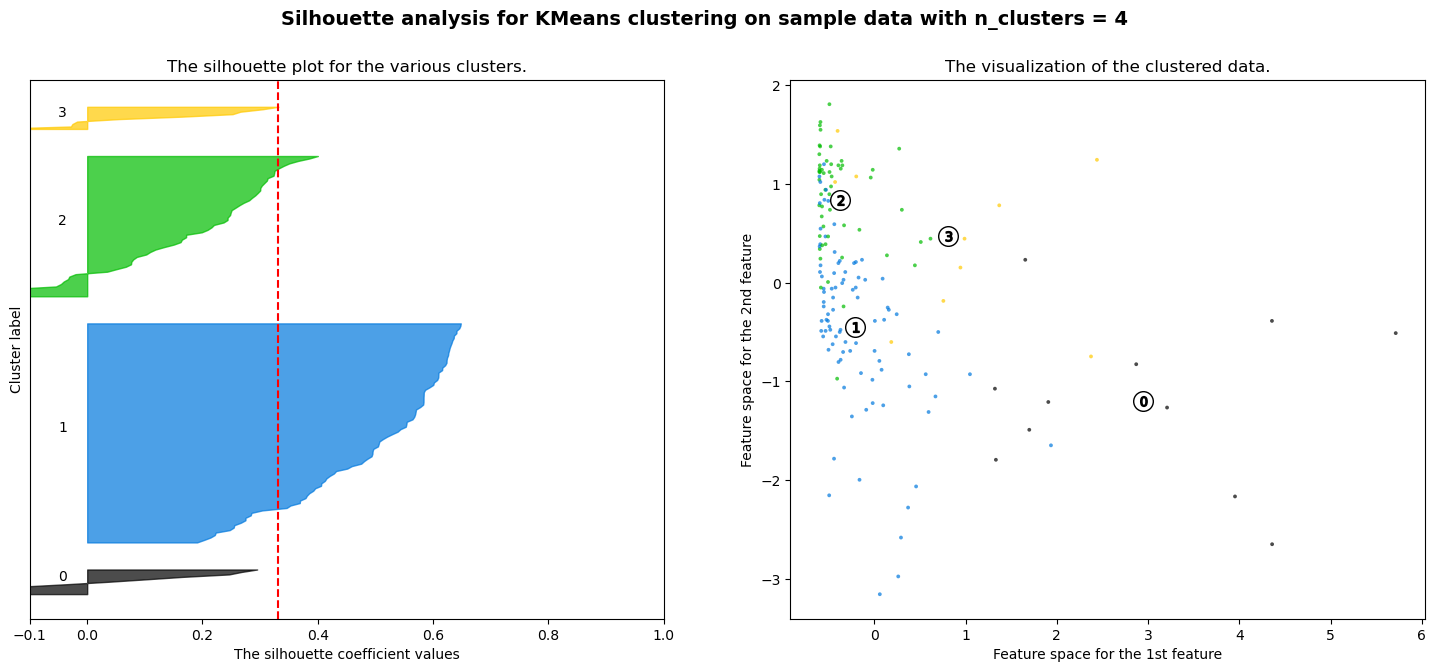

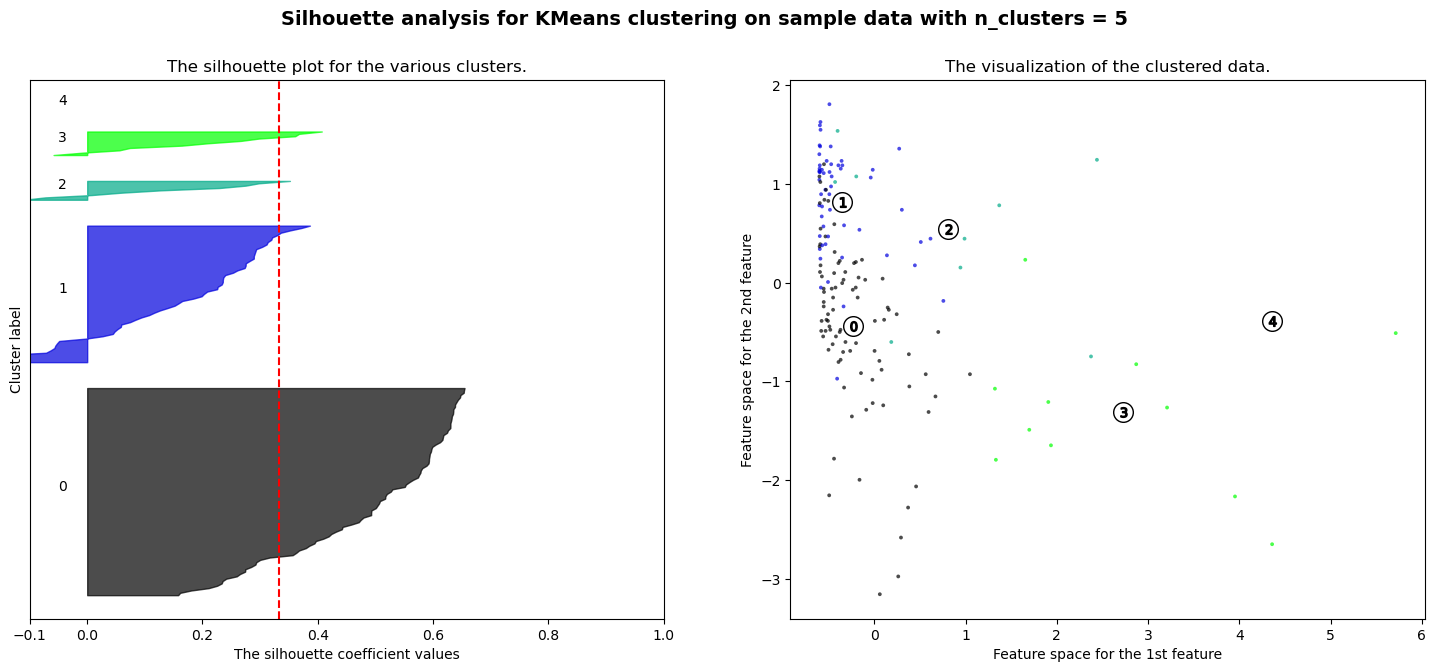

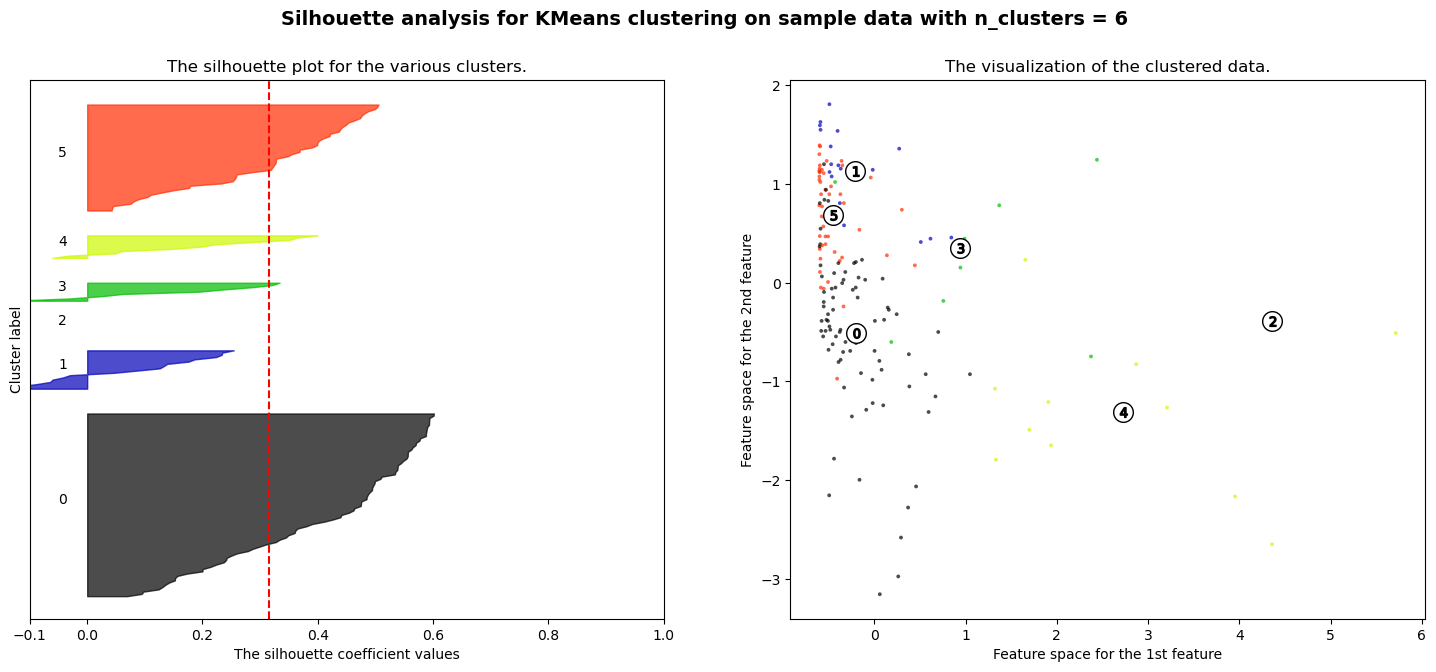

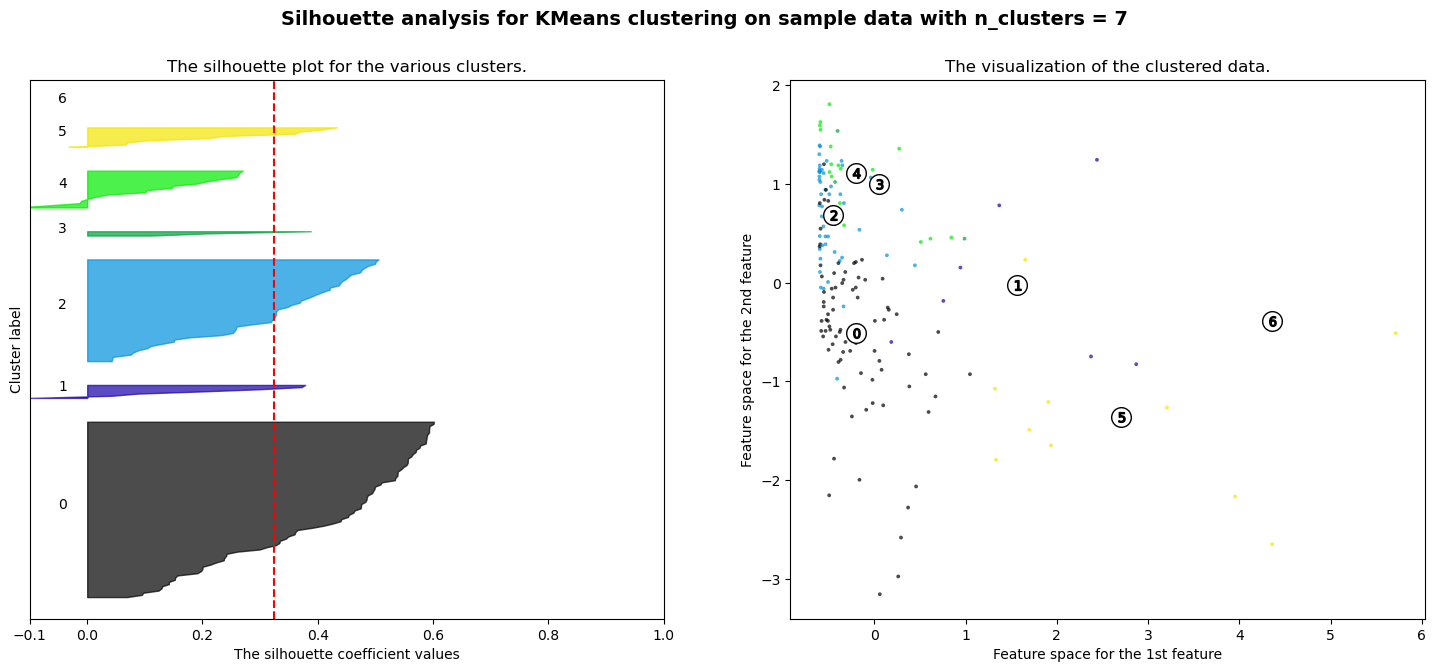

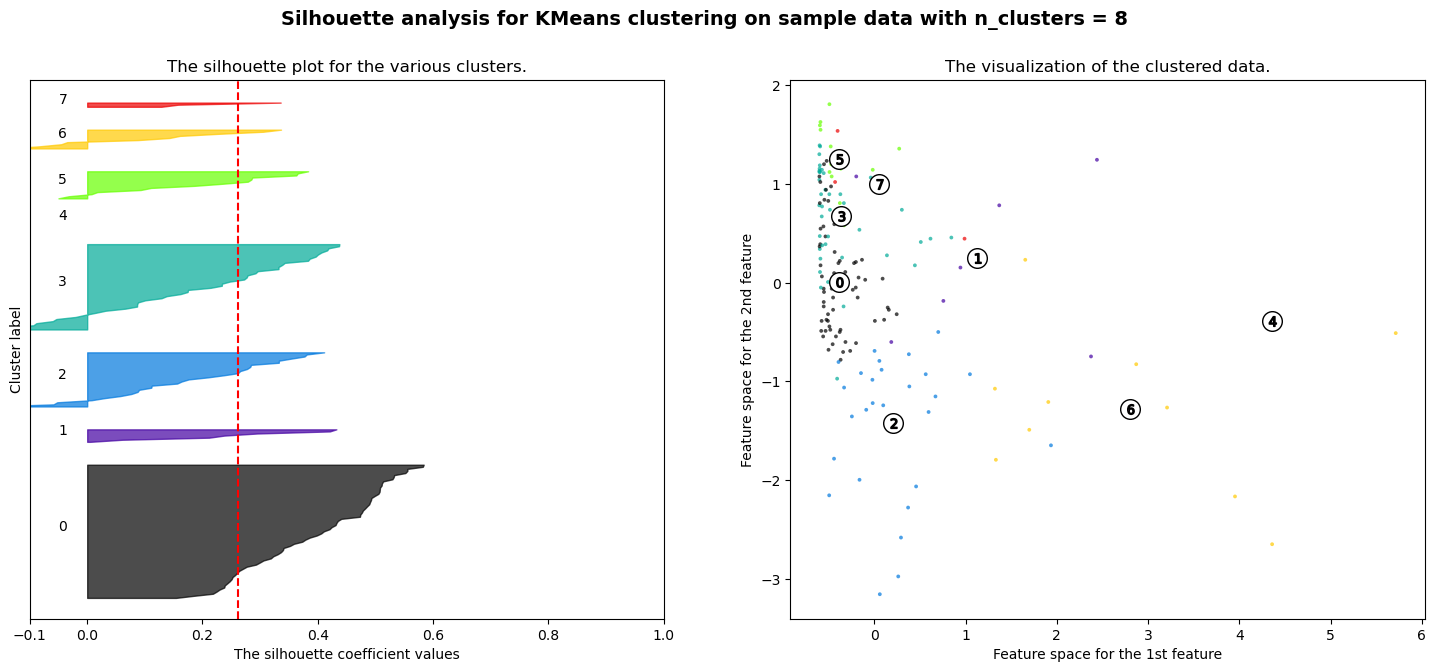

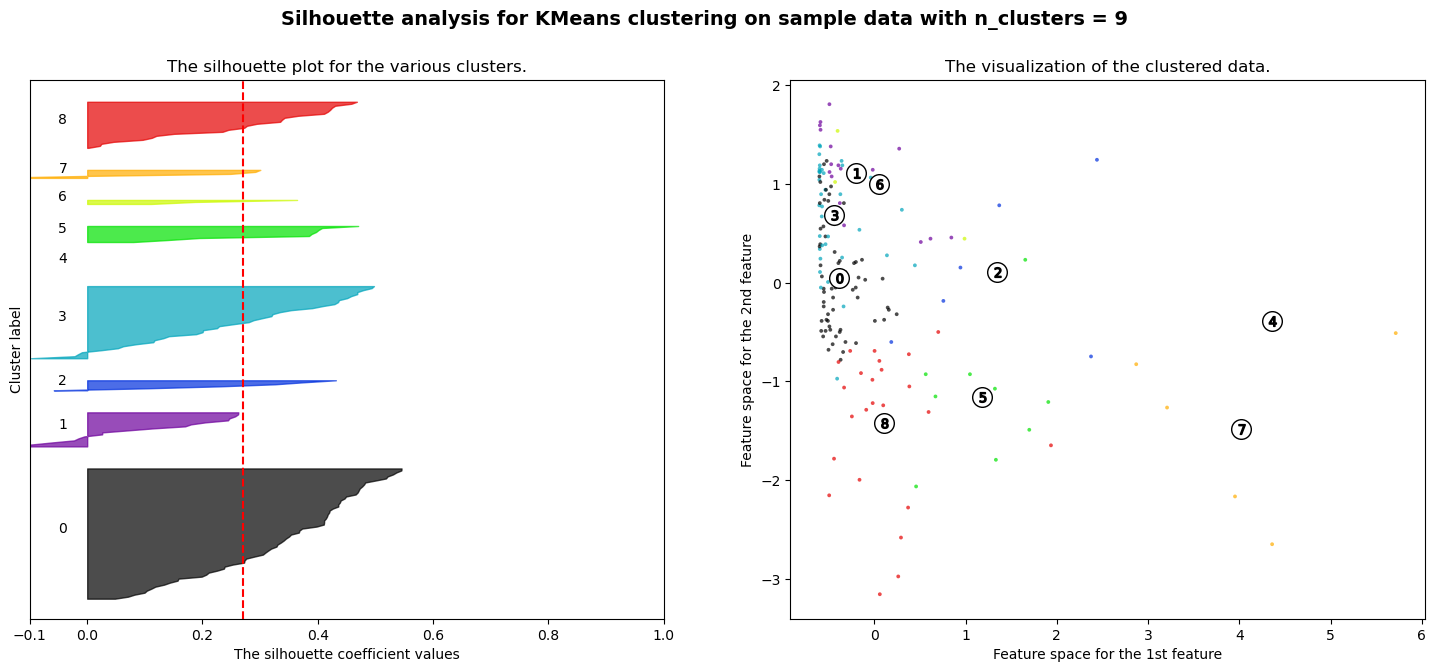

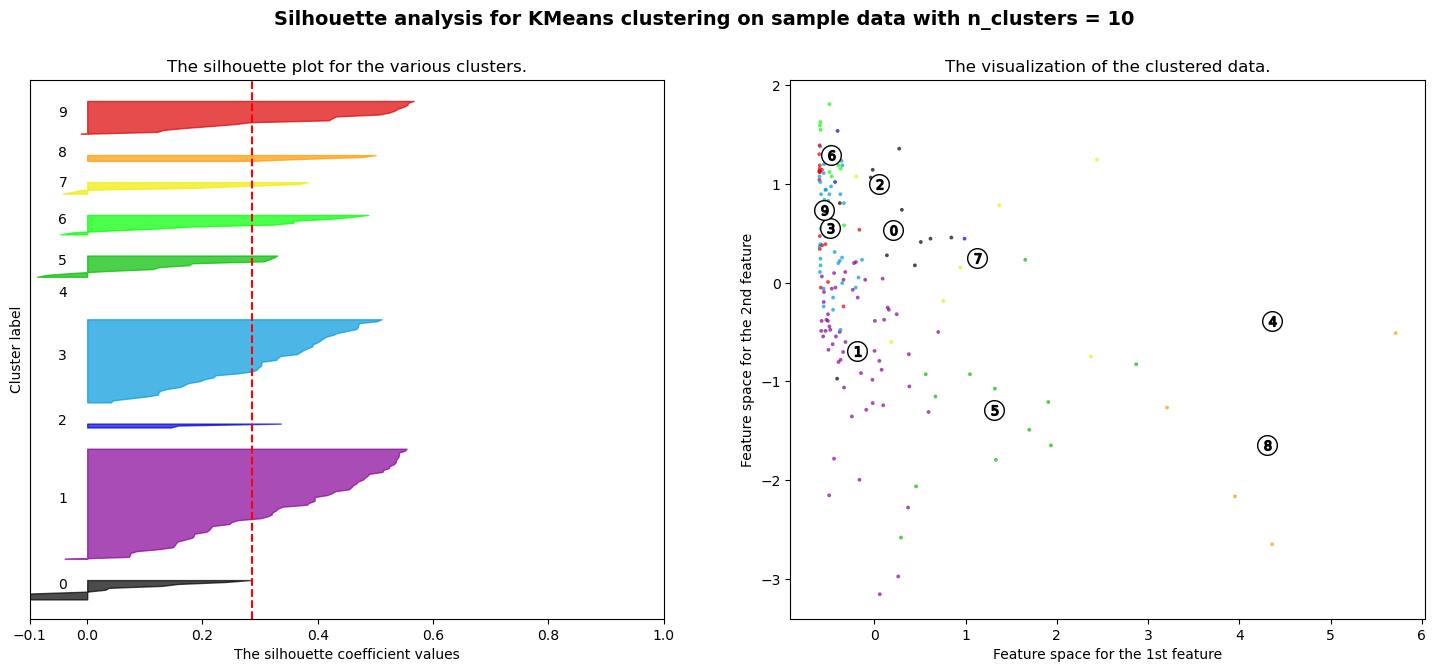

In [1245]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init= 10, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_scaled[:, 0], X_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### > on determine le nombre de clusters optimale, on choisit 4

### On applique le kmeans

In [1246]:
kmeans2 = KMeans(n_clusters=4,random_state=42) # random pour avoir toujours la meme initialisation
kmeans2.fit(X_scaled)
# Voici les clusters : 
kmeans2.labels_

#on enregistre les clusters dans une variable
k2label = kmeans2.labels_

#Ansi que nos centroides :
kcentroids2 = kmeans2.cluster_centers_

In [1247]:
# Calculer le coefficient de silhouette
silhouette2_coeff = silhouette_score(X_scaled, k2label)
print("Coefficient de silhouette:", silhouette2_coeff)

Coefficient de silhouette: 0.3289485125645959


In [1248]:
df["Clusterkmeans"] = k2label
# Utilise la méthode map() pour renommer les étiquettes de cluster
df['Clusterkmeans'] = df['Clusterkmeans'].map(cluster_names)

In [1249]:
df.head(5)

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17,Clusterach,Clusterkmeans
Pays,,,,,,,,,
Afghanistan,36296113.0,-2.70,5.0,29.0,55.0,51.533897,520.616409,groupe 4,groupe 4
Afrique du Sud,57009756.0,-0.22,143.0,514.0,2035.0,2008.360978,6121.876572,groupe 2,groupe 3
Albanie,2884169.0,0.36,85.0,38.0,47.0,1016.561053,4514.204908,groupe 3,groupe 4
Algérie,41389189.0,-0.99,22.0,2.0,264.0,1232.341924,4109.696001,groupe 4,groupe 4
Allemagne,82658409.0,0.64,71.0,842.0,1609.0,33261.034105,44651.829102,groupe 2,groupe 2


> Recherche de l egalité entre les cluster, ne fonctionne pas tres bien car le numero des groupes ne correspondent pas ...

In [1250]:
df['Egalite1'] = df.apply(lambda row: 1 if row['Clusterach'] == row['Clusterkmeans'] else 0, axis=1)

In [1251]:
pourcentage_egalite1 = round((df['Egalite1'].sum() * 100) / (len(df.index)),2)
print(pourcentage_egalite1)

44.97


In [1252]:
df.reset_index(inplace=True)

In [1253]:
df

,Pays,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17,Clusterach,Clusterkmeans,Egalite1
0,Afghanistan,36296113.0,-2.70,5.0,29.0,55.0,51.533897,520.616409,groupe 4,groupe 4,1
1,Afrique du Sud,57009756.0,-0.22,143.0,514.0,2035.0,2008.360978,6121.876572,groupe 2,groupe 3,0
2,Albanie,2884169.0,0.36,85.0,38.0,47.0,1016.561053,4514.204908,groupe 3,groupe 4,0
3,Algérie,41389189.0,-0.99,22.0,2.0,264.0,1232.341924,4109.696001,groupe 4,groupe 4,1
4,Allemagne,82658409.0,0.64,71.0,842.0,1609.0,33261.034105,44651.829102,groupe 2,groupe 2,1
...,...,...,...,...,...,...,...,...,...,...,...
164,Égypte,96442591.0,-1.38,50.0,110.0,1250.0,13163.100000,2023.331158,groupe 1,groupe 3,0
165,Émirats arabes unis,9487203.0,0.66,147.0,433.0,412.0,10354.223000,40644.804043,groupe 3,groupe 1,0
166,Équateur,16785361.0,-0.10,83.0,0.0,324.0,629.542412,6213.501276,groupe 3,groupe 4,0
167,Éthiopie,106399924.0,-1.52,0.0,1.0,14.0,4017.100000,721.753494,groupe 1,groupe 3,0


### Creation de listes pour afficher les groupes 

In [1254]:
# Grouper les noms de pays par groupe pour chaque colonne "Cluster"
groupes_ach = df.groupby('Clusterach')['Pays'].apply(list)
groupes_kmeans = df.groupby('Clusterkmeans')['Pays'].apply(list)


# Récupérer les listes pour chaque groupe pour chaque colonne 'Cluster'
groupe1_ach = groupes_ach['groupe 1']
groupe2_ach = groupes_ach['groupe 2']
groupe3_ach = groupes_ach['groupe 3']
groupe4_ach = groupes_ach['groupe 4']
#groupe5_ach = groupes_ach['groupe 5']
#groupe6_ach = groupes_ach['groupe 6']

groupe1_kmeans = groupes_kmeans['groupe 1']
groupe2_kmeans = groupes_kmeans['groupe 2']
groupe3_kmeans = groupes_kmeans['groupe 3']
groupe4_kmeans = groupes_kmeans['groupe 4']
#groupe5_kmeans = groupes_kmeans['groupe 5']
#groupe6_kmeans = groupes_kmeans['groupe 6']

## Groupe avec la methode ACH

In [1255]:
print(groupe1_ach)
print(len(groupe1_ach))
print('#################################')
print(groupe2_ach)
print(len(groupe2_ach))
print('#################################')
print(groupe3_ach)
print(len(groupe3_ach))
print('#################################')
print(groupe4_ach)
print(len(groupe4_ach))
#print('#################################')
#print(groupe5_ach)
#print(len(groupe5_ach))
#print('#################################')
#print(groupe6_ach)
#print(len(groupe6_ach))##

['Bangladesh', 'Brésil', 'Colombie', 'Fédération de Russie', 'Indonésie', "Iran (République islamique d')", 'Myanmar', 'Nigéria', 'Pakistan', 'Philippines', 'Thaïlande', 'Turquie', 'Ukraine', 'Viet Nam', 'Égypte', 'Éthiopie']
16
#################################
['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Chine - RAS de Hong-Kong', 'France', 'Japon', 'Mexique', 'Pays-Bas', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suisse']
10
#################################
['Albanie', 'Antigua-et-Barbuda', 'Argentine', 'Australie', 'Autriche', 'Bahamas', 'Barbade', 'Belgique', 'Belize', 'Bolivie (État plurinational de)', 'Botswana', 'Bulgarie', 'Bélarus', 'Cabo Verde', 'Canada', 'Chili', 'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Chypre', 'Costa Rica', 'Croatie', 'Danemark', 'Dominique', 'Espagne', 'Estonie', 'Fidji', 'Finlande', 'Gabon', 'Grenade', 'Guyana', 'Hongrie', 'Irlande', 'Islande', 'Israël', 'Italie', 'Jamaïque', 'Kiribati', 'Koweït', 'Lettonie', 'Lituanie'

## Groupe avec la methode K means

In [1256]:
print(groupe1_kmeans)
print(len(groupe1_kmeans))
print('#################################')
print(groupe2_kmeans)
print(len(groupe2_kmeans))
print('#################################')
print(groupe3_kmeans)
print(len(groupe3_kmeans))
print('#################################')
print(groupe4_kmeans)
print(len(groupe4_kmeans))
#print('#################################')
#print(groupe5_kmeans)
#print(len(groupe5_kmeans))
#print('#################################')
#print(groupe6_kmeans)
#print(len(groupe6_kmeans))

['Antigua-et-Barbuda', 'Argentine', 'Australie', 'Autriche', 'Bahamas', 'Barbade', 'Belgique', 'Bolivie (État plurinational de)', 'Canada', 'Chili', 'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Chypre', 'Costa Rica', 'Cuba', 'Danemark', 'Dominique', 'Espagne', 'Estonie', 'Fidji', 'Finlande', 'Grenade', 'Guyana', 'Hongrie', 'Irlande', 'Islande', 'Israël', 'Italie', 'Jamaïque', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg', 'Malaisie', 'Malte', 'Maurice', 'Norvège', 'Nouvelle-Calédonie', 'Nouvelle-Zélande', 'Oman', 'Panama', 'Pologne', 'Polynésie française', 'Portugal', 'République de Corée', 'République dominicaine', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Slovaquie', 'Slovénie', 'Suriname', 'Suède', 'Tchéquie', 'Trinité-et-Tobago', 'Uruguay', 'Émirats arabes unis']
58
#################################
['Allemagne', 'Arabie saoudite', 'Chine - RAS de Hong-Kong', 'France', 'Japon', 'Mexique', 'Pays-Bas', "Royaume-Uni de Grande-Bretag

> Pas exactement les memes groupes, `Afrique du sud` qui oscille entre 2 groupes 
> Gardons a l esprit le `groupe 2`

# Boxplot

In [1257]:
columns_list = df.columns.tolist()
columns_list = columns_list[1:-3] # Créer une sous-liste qui commence à l'indice 1 et se termine a -3

In [1258]:
columns_list

['pop_2017',
 'indexpolitic',
 'Disponibilité alimentaire (Kcal/personne/jour)',
 'Importations - Quantité',
 'Nourriture',
 'Investment',
 'Pib_hab17']

## Compare les groupes des deux methodes differentes

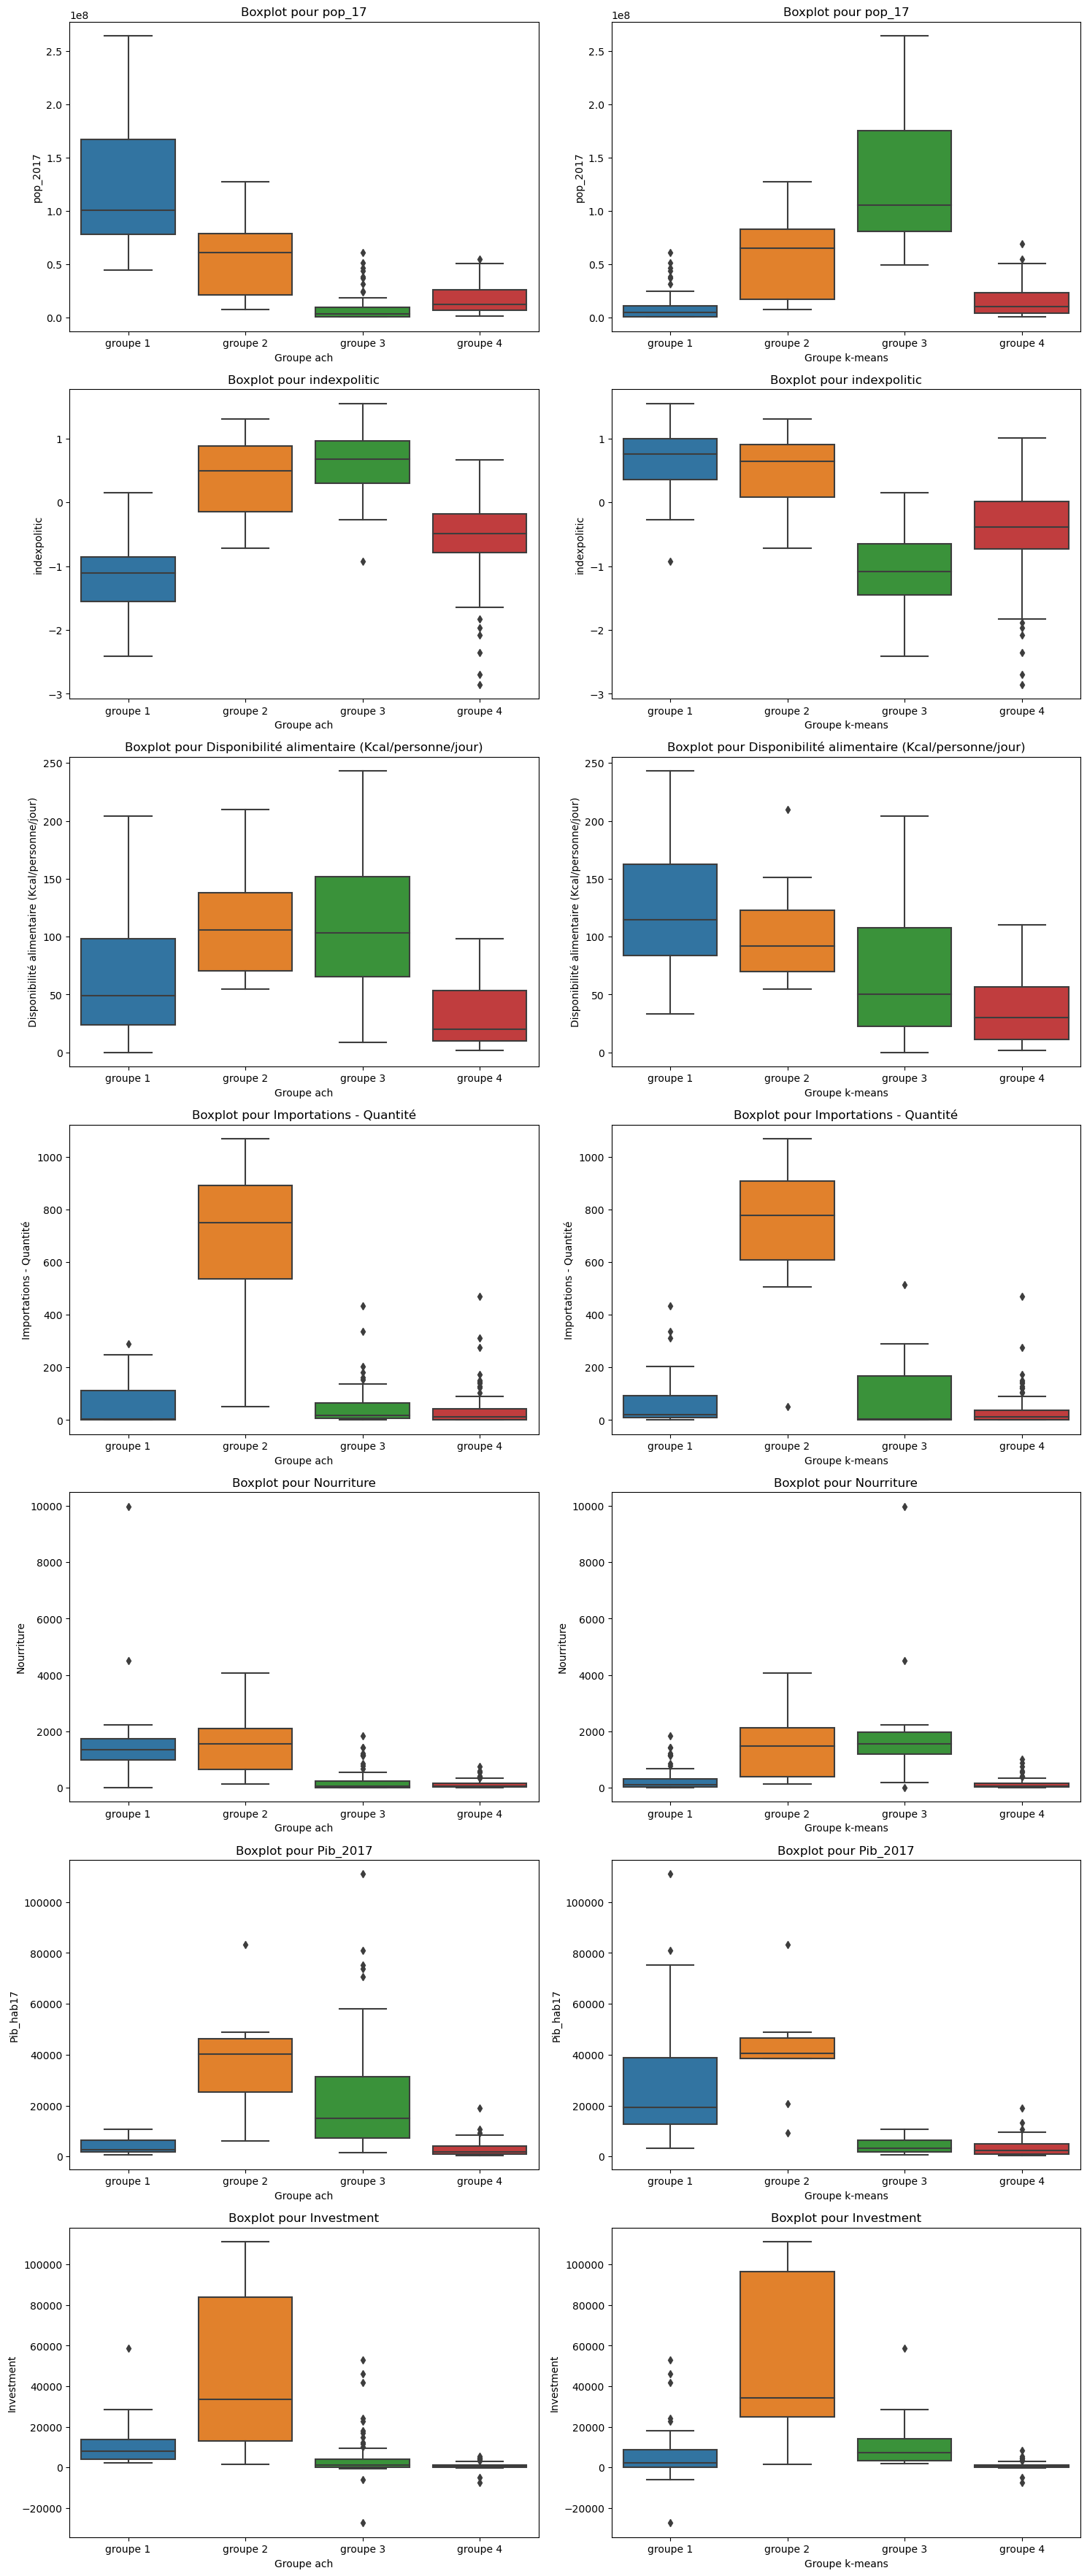

In [1259]:
plt.figure(figsize=(15, 40))

plt.subplot(8, 2, 1)
sns.boxplot(data=df, x="Clusterach", y="pop_2017", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour pop_17")
plt.xlabel("Groupe ach")

plt.subplot(8, 2, 2)
sns.boxplot(data=df, x="Clusterkmeans", y="pop_2017", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour pop_17")
plt.xlabel("Groupe k-means")


plt.subplot(8, 2, 3)
sns.boxplot(data=df, x="Clusterach", y="indexpolitic", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour indexpolitic")
plt.xlabel("Groupe ach")


plt.subplot(8, 2, 4)
sns.boxplot(data=df, x="Clusterkmeans", y="indexpolitic", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour indexpolitic")
plt.xlabel("Groupe k-means")




plt.subplot(8, 2, 5)
sns.boxplot(data=df, x="Clusterach", y="Disponibilité alimentaire (Kcal/personne/jour)", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Disponibilité alimentaire (Kcal/personne/jour)")
plt.xlabel("Groupe ach")

plt.subplot(8, 2, 6)
sns.boxplot(data=df, x="Clusterkmeans", y="Disponibilité alimentaire (Kcal/personne/jour)", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Disponibilité alimentaire (Kcal/personne/jour)")
plt.xlabel("Groupe k-means")


plt.subplot(8, 2, 7)
sns.boxplot(data=df, x="Clusterach", y="Importations - Quantité", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Importations - Quantité")
plt.xlabel("Groupe ach")


plt.subplot(8, 2, 8)
sns.boxplot(data=df, x="Clusterkmeans", y="Importations - Quantité", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Importations - Quantité")
plt.xlabel("Groupe k-means")

plt.subplot(8, 2, 9)
sns.boxplot(data=df, x="Clusterach", y="Nourriture", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Nourriture")
plt.xlabel("Groupe ach")

plt.subplot(8, 2, 10)
sns.boxplot(data=df, x="Clusterkmeans", y="Nourriture", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Nourriture")
plt.xlabel("Groupe k-means")


plt.subplot(8, 2, 11)
sns.boxplot(data=df, x="Clusterach", y="Pib_hab17", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Pib_2017")
plt.xlabel("Groupe ach")


plt.subplot(8, 2, 12)
sns.boxplot(data=df, x="Clusterkmeans", y="Pib_hab17", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Pib_2017")
plt.xlabel("Groupe k-means")




plt.subplot(8, 2, 13)
sns.boxplot(data=df, x="Clusterach", y="Investment", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Investment")
plt.xlabel("Groupe ach")

plt.subplot(8, 2, 14)
sns.boxplot(data=df, x="Clusterkmeans", y="Investment", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
plt.title("Boxplot pour Investment")
plt.xlabel("Groupe k-means")


#plt.subplot(8, 2, 15)
#sns.boxplot(data=df, x="Clusterach", y="TCAM", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
#plt.title("Boxplot pour Pib_hab17")
#plt.xlabel("Groupe ach")

#plt.subplot(8, 2, 16)
#sns.boxplot(data=df, x="Clusterkmeans", y="TCAM", order=['groupe 1', 'groupe 2', 'groupe 3', 'groupe 4'])
#plt.title("Boxplot pour Pib_hab17")
#plt.xlabel("Groupe k-means")



plt.tight_layout()
plt.savefig('test2.jpg', format='jpg')
plt.show()


# Radar chart

#### Compare les groupes avec leurs centroides de la methode KMEANS

In [1260]:
df.set_index(['Pays'], inplace=True) # defini comme index

In [1261]:
df = df.drop(columns=['Clusterach','Clusterkmeans','Egalite1'])

In [1262]:
df.head(5)

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17
Pays,,,,,,,
Afghanistan,36296113.0,-2.70,5.0,29.0,55.0,51.533897,520.616409
Afrique du Sud,57009756.0,-0.22,143.0,514.0,2035.0,2008.360978,6121.876572
Albanie,2884169.0,0.36,85.0,38.0,47.0,1016.561053,4514.204908
Algérie,41389189.0,-0.99,22.0,2.0,264.0,1232.341924,4109.696001
Allemagne,82658409.0,0.64,71.0,842.0,1609.0,33261.034105,44651.829102


In [1263]:
df.shape

(169, 7)

In [1264]:
list_colonne_df = df.columns
list_colonne_df = np.concatenate((list_colonne_df,[list_colonne_df[0]]))

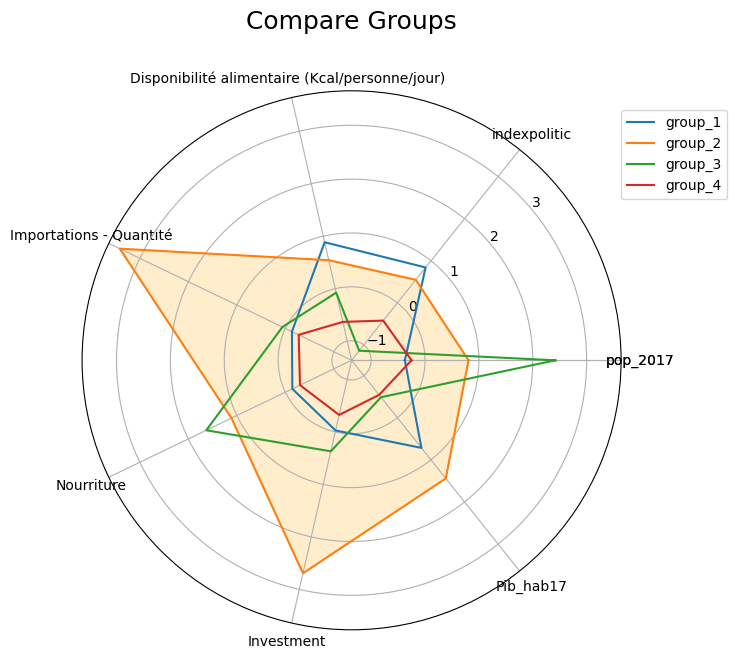

In [1265]:
# data
categories = list_colonne_df


group_1 = kcentroids2[0]
group_1 = np.concatenate((group_1,[group_1[0]]))

group_2 = kcentroids2[1]
group_2 = np.concatenate((group_2,[group_2[0]]))

group_3 = kcentroids2[2]
group_3 = np.concatenate((group_3,[group_3[0]]))

group_4 = kcentroids2[3]
group_4 = np.concatenate((group_4,[group_4[0]]))

# calculate evenly-spaced angle coordinates
# use radians for polar plot with 2*np.pi
label_placement = np.linspace(start=0, stop=2*np.pi, num=len(group_1))

# create matplotlib figure and polar plot with labels, title, and legend
plt.figure(figsize=(7,7))
plt.subplot(polar=True)


plt.plot(label_placement, group_1)
plt.plot(label_placement, group_2)
plt.plot(label_placement, group_3)
plt.plot(label_placement, group_4)


#plt.fill(label_placement, group_1, c='blue',alpha=0.1,)
plt.fill(label_placement, group_2, alpha=0.2, c='orange')
#plt.fill(label_placement, group_3,c='green', alpha=0.2,)
#plt.fill(label_placement, group_4, alpha=0.1,)


# use thetagrids to place labels at the specified angles using degrees

lines, labels = plt.thetagrids(np.degrees(label_placement), labels=categories)
plt.title('Compare Groups', y=1.1, fontdict={'fontsize': 18})
#plt.legend(labels=['group_1','group_2'],loc=(1, 0.8))
plt.legend(labels=['group_1','group_2', 'group_3','group_4'],loc=(1, 0.8))
plt.rgrids(range(-1,4), angle=40)
plt.show()

In [1266]:
# Nous enregistrons les noms de nos cours dans une variable names :

names = df.index

# et nos colonnes, nos features, dans une variable features :

features = df.columns

# ACP


In [1267]:
# On espère avoir une moyenne à 0 et un écart type à 1 :

idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6
mean,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [1268]:
# Nous allons travailler que sur les 6 premières composantes : 

n_components = 6

In [1269]:
# On instancie notre ACP : 

pca = PCA(n_components=n_components)

# On l'entraine sur les données scalées :

pca.fit(X_scaled)

PCA(n_components=6)

In [1270]:
# Intéressons nous maintenant à la variance captée par chaque nouvelle composante. Grace à scikit-learn on peut utiliser l'attribut explained_variance_ratio_ :

pca.explained_variance_ratio_

array([0.35216719, 0.29421593, 0.11858605, 0.08412474, 0.06682712,
       0.05156032])

## Critere de kaiser 


In [1271]:
# Critère de Kaiser
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
num_factors = np.sum(pca.explained_variance_ > 1)

print("Valeurs propres :", pca.explained_variance_)
print("Somme cumulée des valeurs propres :", cumulative_sum)
print("Nombre de facteurs à retenir :", num_factors)

Valeurs propres : [2.47984395 2.07177053 0.83504346 0.59237835 0.47057434 0.36307059]
Somme cumulée des valeurs propres : [0.35216719 0.64638312 0.76496918 0.84909391 0.91592104 0.96748136]
Nombre de facteurs à retenir : 2


####  Ici la 1ère composante capte 35 % de la variance de nos données initiales, la 2ème 29 % etc etc.


In [1272]:
# Enregistrons cela dans une variable :

scree = (pca.explained_variance_ratio_*100).round(2)
scree


array([35.22, 29.42, 11.86,  8.41,  6.68,  5.16])

#### Les 2 premières composantes captent donc xx+xx = xx% de la variance, les 3 premières xx+xx+xx = xx% de la variance etc etc Dans le jargon, cela s'appelle une somme cumulée. Et pour faire une somme cumulée numpy dispose de la fonction cumsum :

In [1273]:
scree_cum = scree.cumsum().round()
scree_cum

array([35., 65., 76., 85., 92., 97.])

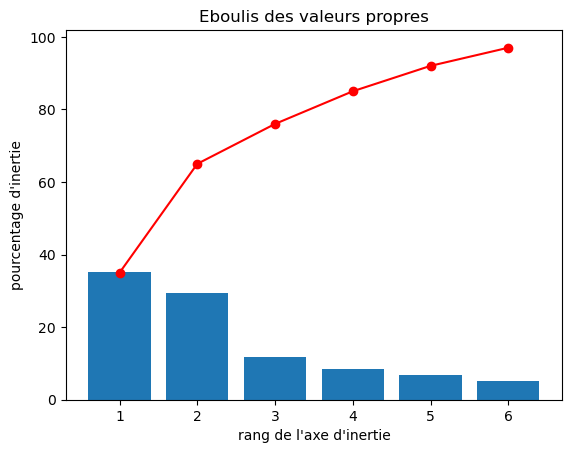

In [1274]:
# Définisons ensuite une variable avec la liste de nos composantes :

x_list = range(1, n_components+1)
list(x_list)

# On peut enfin l'afficher de façon graphique :

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

#### Intéressons nous maintenant à nos fameuses composantes. Nous avons dit dans le cours que c'est bien par un calcul que l'on obtient ces composantes. La formule de ce calcul nous est donnée par l'attribut components_. Cette variable est généralement nommée pcs :

In [1275]:
pcs = pca.components_
pcs

array([[ 0.23101047,  0.24596589,  0.35982683,  0.43312793,  0.41003294,
         0.49728562,  0.39196913],
       [ 0.5623258 , -0.54570304, -0.2795803 ,  0.1169305 ,  0.39803718,
         0.06655545, -0.36234898],
       [ 0.11731595,  0.0804747 ,  0.67317962, -0.47130286,  0.39213882,
        -0.30788578, -0.23642565],
       [ 0.33227203,  0.11114977, -0.34615918, -0.6756508 ,  0.08863185,
         0.14556016,  0.52140912],
       [-0.32601377, -0.22662862,  0.12889582, -0.34634741, -0.07161935,
         0.77679291, -0.31184494],
       [-0.00346892, -0.72871652,  0.37928518,  0.01172427, -0.26319973,
        -0.0967891 ,  0.49630964]])

In [1276]:
# Affichons la même chose mais version pandas :

pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6
0,0.231010,0.245966,0.359827,0.433128,0.410033,0.497286,0.391969
1,0.562326,-0.545703,-0.279580,0.116931,0.398037,0.066555,-0.362349
2,0.117316,0.080475,0.673180,-0.471303,0.392139,-0.307886,-0.236426
3,0.332272,0.111150,-0.346159,-0.675651,0.088632,0.145560,0.521409
4,-0.326014,-0.226629,0.128896,-0.346347,-0.071619,0.776793,-0.311845
5,-0.003469,-0.728717,0.379285,0.011724,-0.263200,-0.096789,0.496310


In [1277]:
# Intéressant... Mais pas encore très clair... Continuons le travail :

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,pop_2017,indexpolitic,Disponibilité alimentaire (Kcal/personne/jour),Importations - Quantité,Nourriture,Investment,Pib_hab17
F1,0.23,0.25,0.36,0.43,0.41,0.50,0.39
F2,0.56,-0.55,-0.28,0.12,0.40,0.07,-0.36
F3,0.12,0.08,0.67,-0.47,0.39,-0.31,-0.24
F4,0.33,0.11,-0.35,-0.68,0.09,0.15,0.52
F5,-0.33,-0.23,0.13,-0.35,-0.07,0.78,-0.31
F6,-0.00,-0.73,0.38,0.01,-0.26,-0.10,0.50


#### -- ATTENTION -- : Nous avons arrondi les résultats pour simplifier l'analyse 

In [1278]:
pcs.T    # inverse le df

,F1,F2,F3,F4,F5,F6
pop_2017,0.231010,0.562326,0.117316,0.332272,-0.326014,-0.003469
indexpolitic,0.245966,-0.545703,0.080475,0.111150,-0.226629,-0.728717
Disponibilité alimentaire (Kcal/personne/jour),0.359827,-0.279580,0.673180,-0.346159,0.128896,0.379285
Importations - Quantité,0.433128,0.116931,-0.471303,-0.675651,-0.346347,0.011724
Nourriture,0.410033,0.398037,0.392139,0.088632,-0.071619,-0.263200
Investment,0.497286,0.066555,-0.307886,0.145560,0.776793,-0.096789
Pib_hab17,0.391969,-0.362349,-0.236426,0.521409,-0.311845,0.496310


# Coef de correlation

<Axes: >

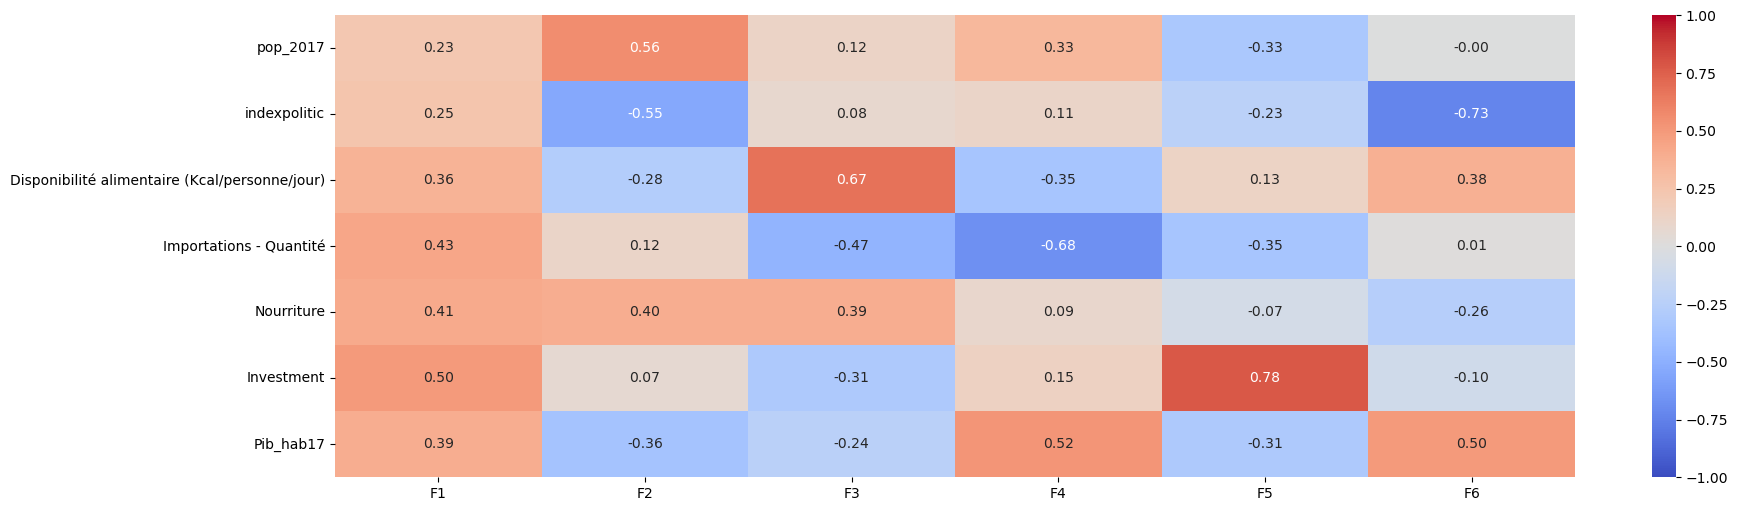

In [1279]:
# graphique

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

#### Essayons cette fonction pour F1 et F2
-- ATTENTION -- Encore une fois Pour F1 et F2 il faut bien préciser 0 et 1 

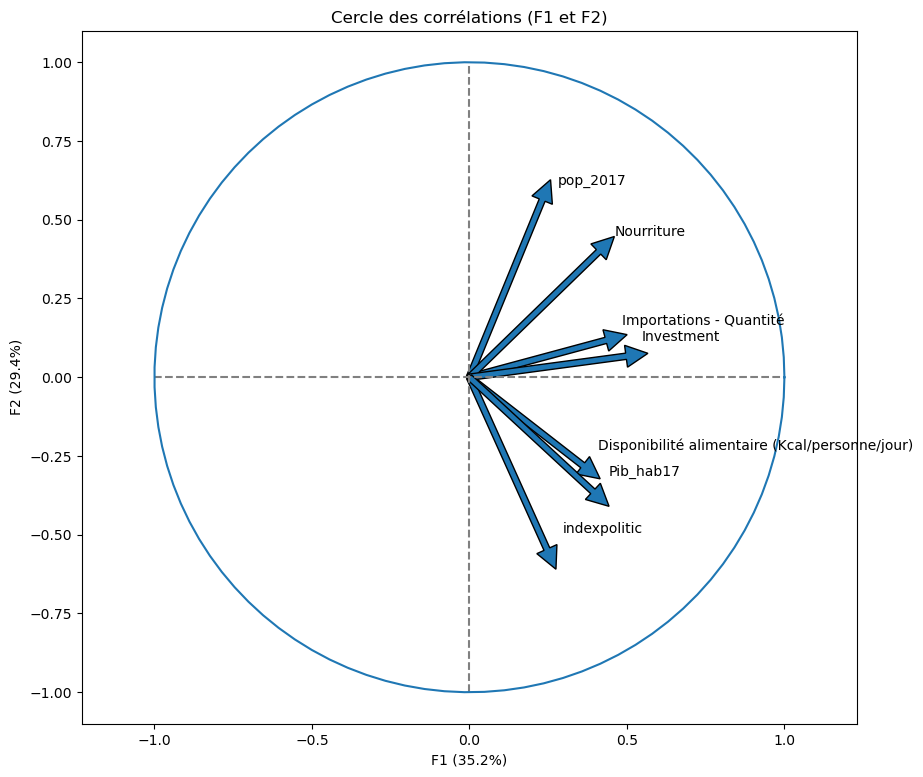

In [1280]:
x_y = (0,1)

correlation_graph(pca, x_y, features)

#### Projection

#### Travaillons maintenant sur la projection de nos dimensions. Tout d'abord calculons les coordonnées de nos individus dans le nouvel espace :

In [1281]:
X_proj = pca.transform(X_scaled)

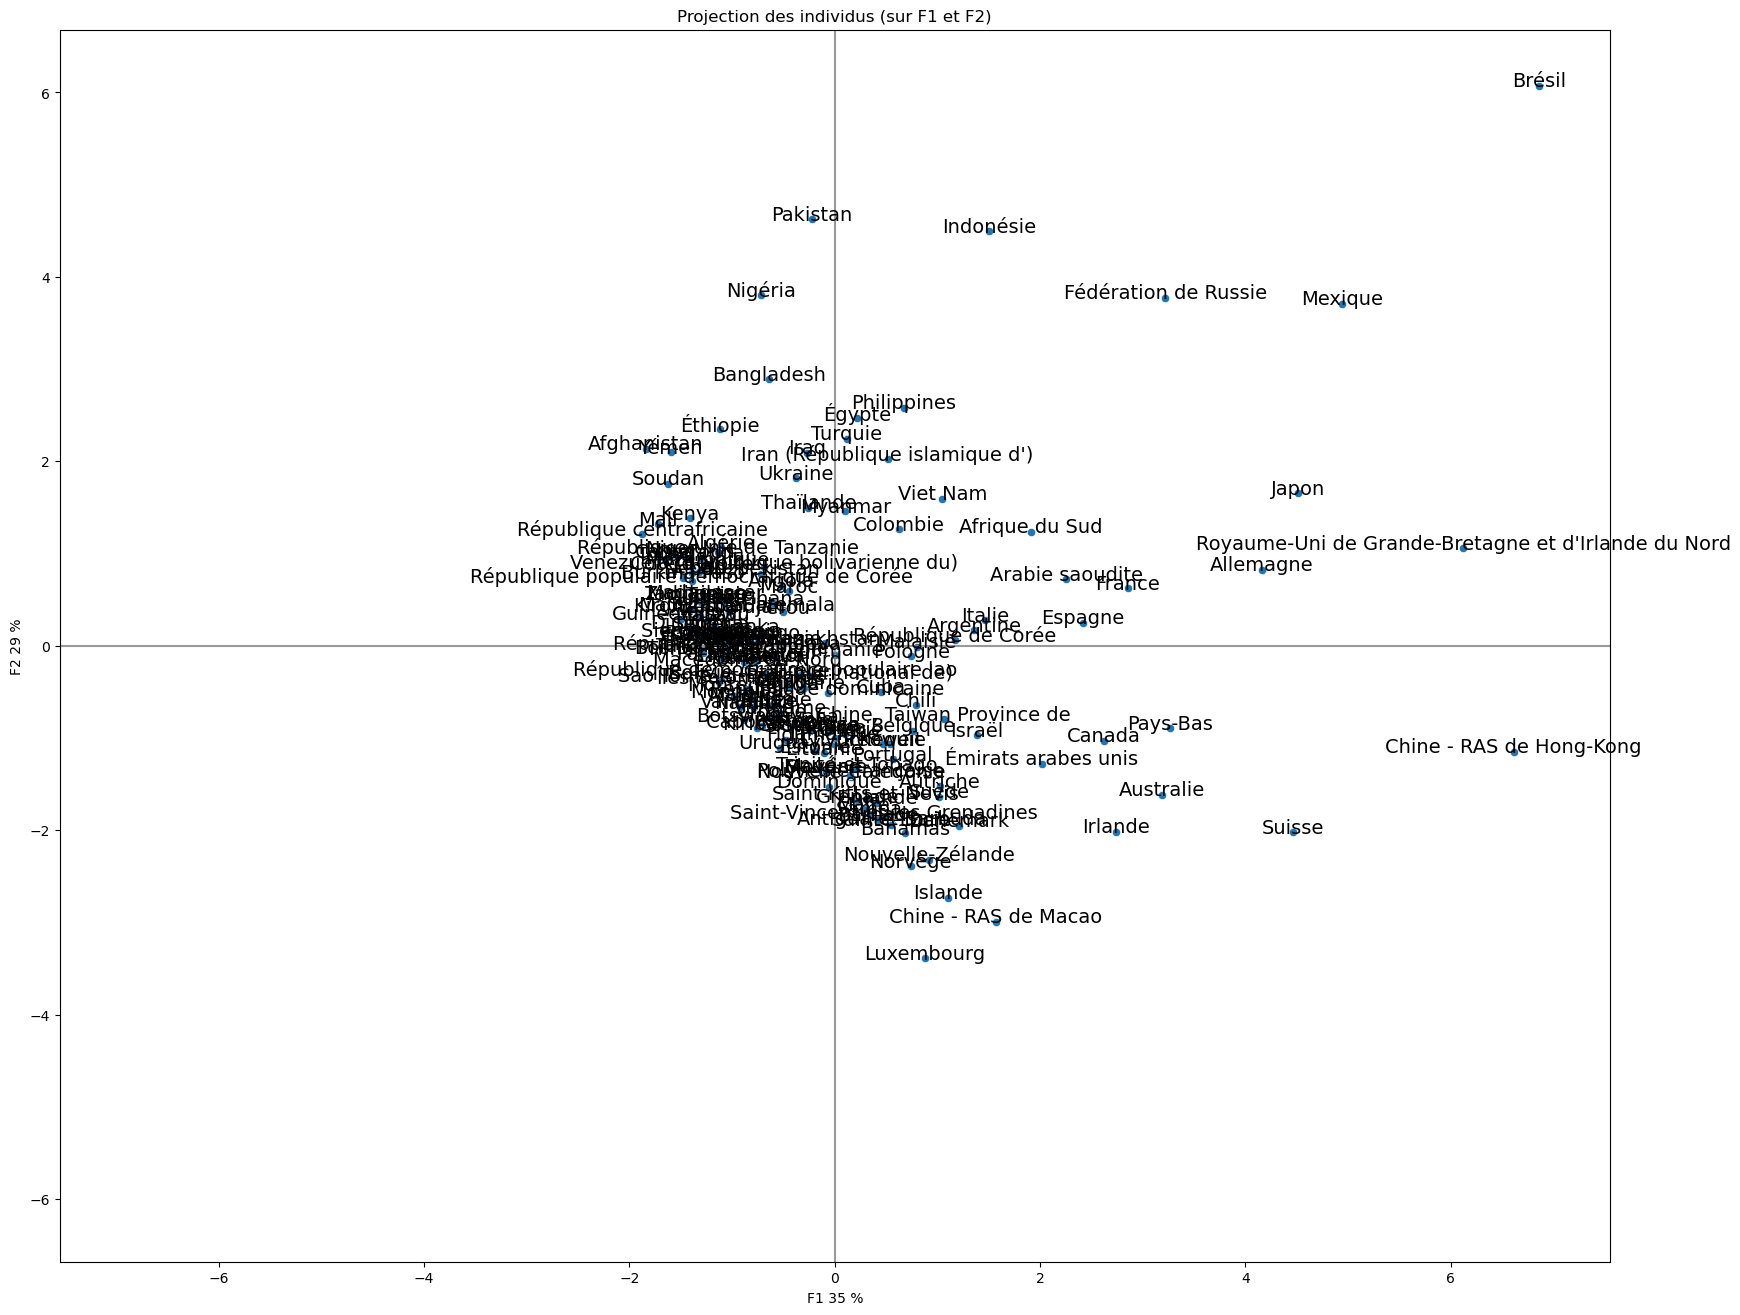

In [1282]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")

#### F2 ET F3

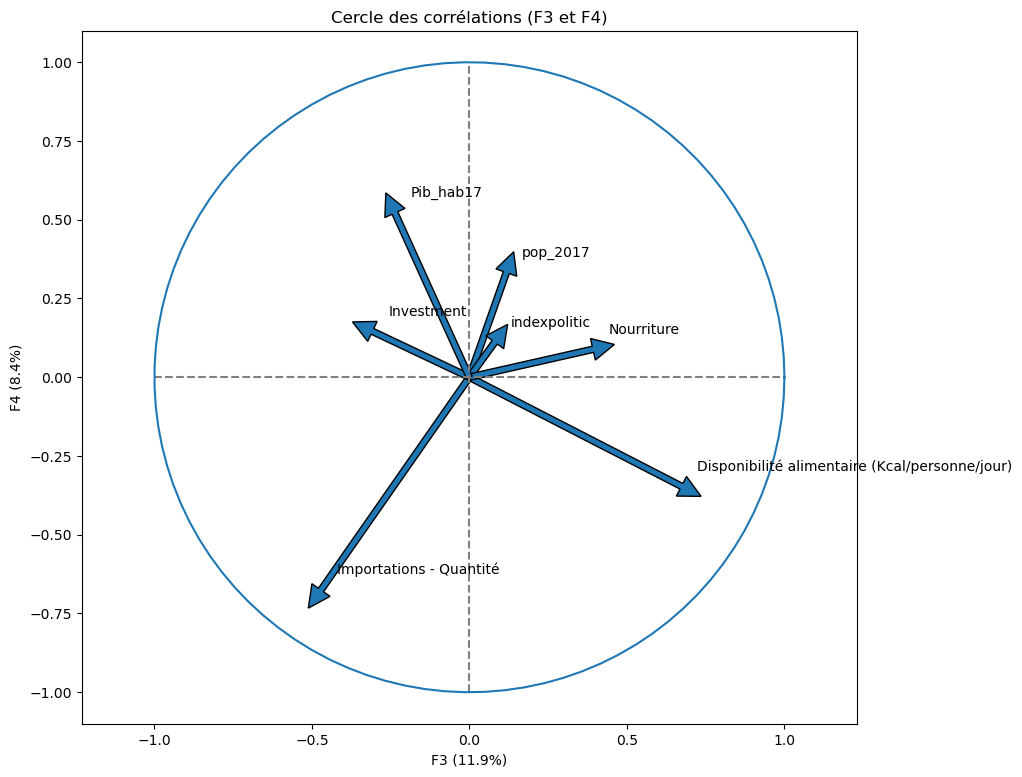

In [1283]:
# Essayons pour F3 et F4 :

correlation_graph(pca, (2,3), features)

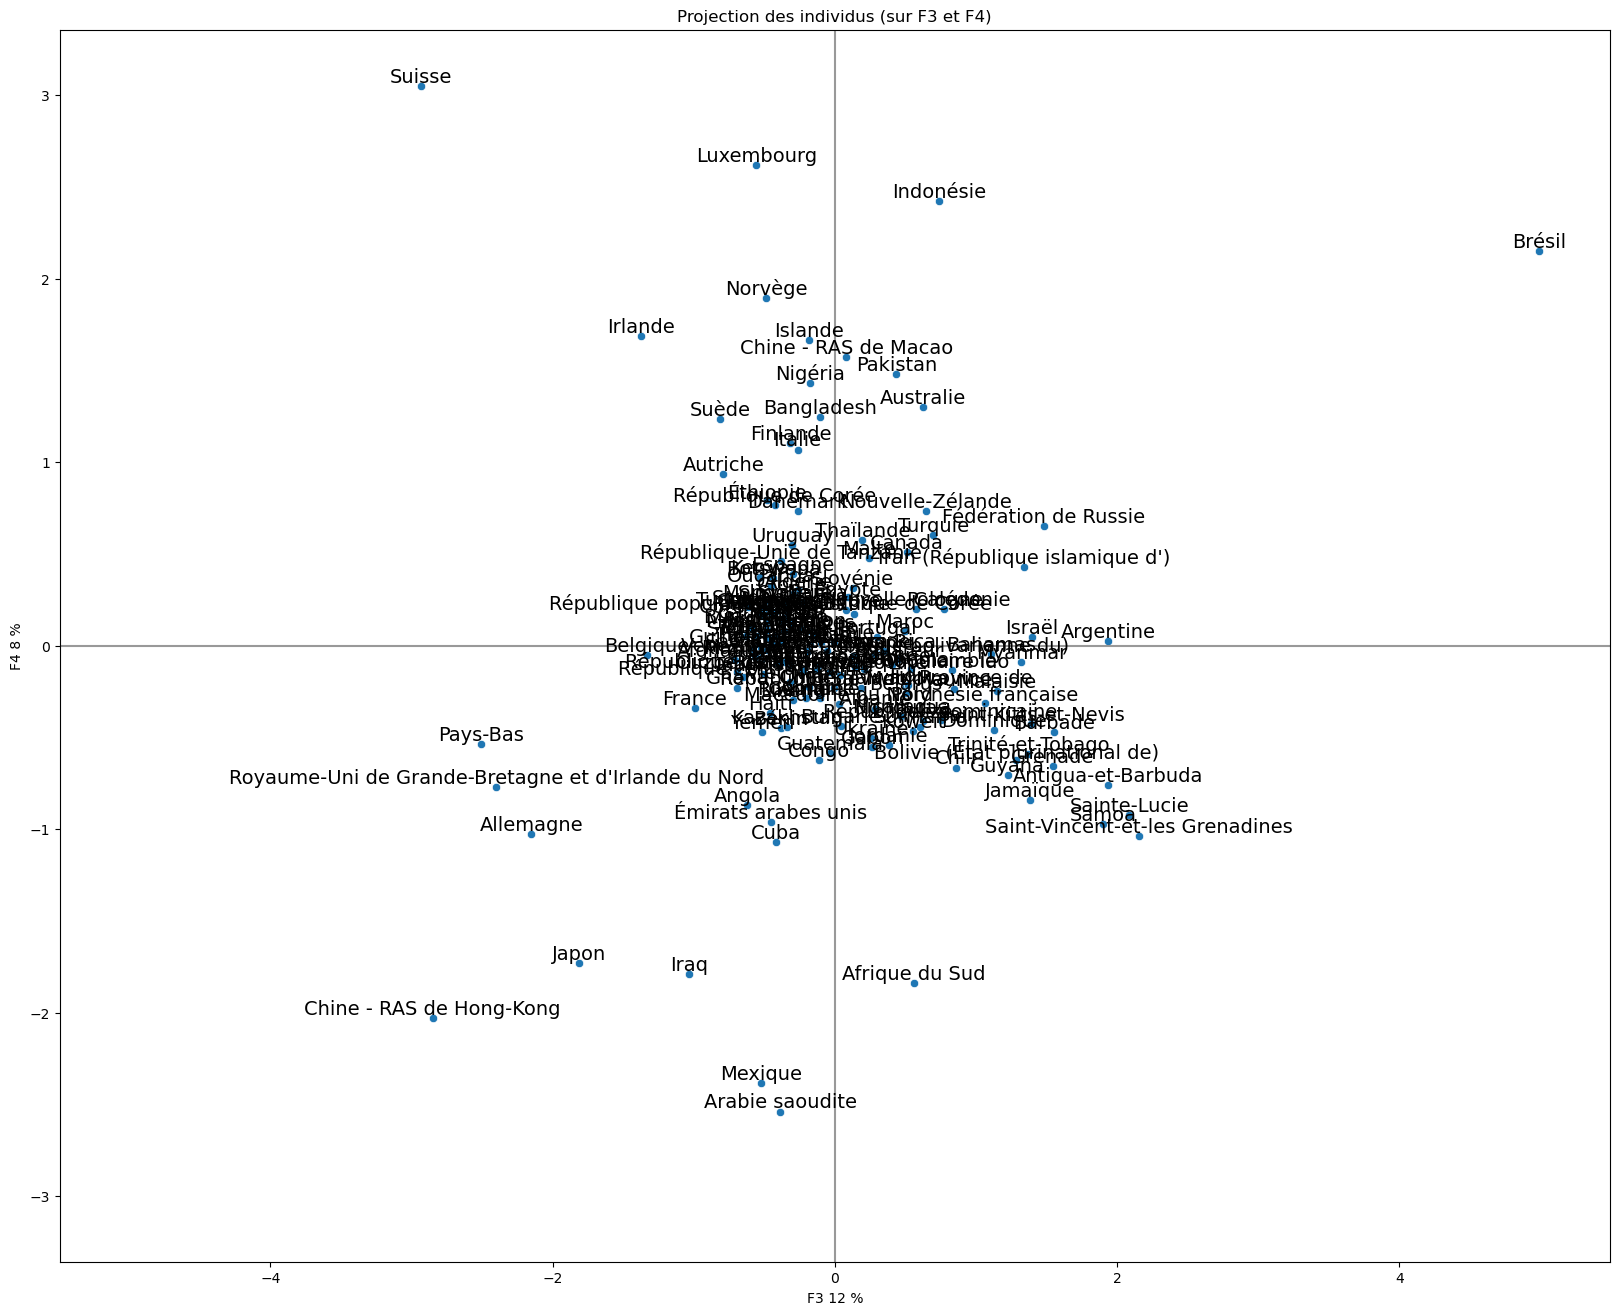

In [1284]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16),marker="o")

### CENTROIDE KMEANS2


In [1285]:
# nos centroides du deuxieme kmeans sans outliers :
kcentroids2

array([[-0.37466462,  0.84083757,  0.8843972 , -0.134945  , -0.14266664,
        -0.02772403,  0.71702717],
       [ 0.80731784,  0.5473444 ,  0.5423387 ,  3.41239597,  1.11120249,
         2.69148521,  1.4417693 ],
       [ 2.41987742, -1.13627035, -0.07589657,  0.06138633,  1.63057462,
         0.36988022, -0.48736624],
       [-0.25095947, -0.42127153, -0.63261652, -0.27362699, -0.30097444,
        -0.32371927, -0.543138  ]])

In [1286]:
centroids_proj = pca.transform(kcentroids2)

In [1287]:
centroids_proj

array([[ 0.58881502, -1.25101629,  0.46573725,  0.111186  , -0.14259852,
         0.11852478],
       [ 4.35347452,  0.50168339, -1.83821763, -0.92222466,  0.06232462,
         0.00663883],
       [ 0.94030468,  2.85946633,  0.75318225,  0.60680144, -0.23992339,
         0.08470614],
       [-1.00502428,  0.28910114, -0.25019007, -0.08334238,  0.1299844 ,
        -0.0943078 ]])

In [1288]:
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns = ["F1", "F2", "F3", "F4","F5", "F6"], 
                              index=["groupe 1", "groupe 2","groupe 3",'groupe 4'])

In [1289]:
centroids_proj

,F1,F2,F3,F4,F5,F6
groupe 1,0.588815,-1.251016,0.465737,0.111186,-0.142599,0.118525
groupe 2,4.353475,0.501683,-1.838218,-0.922225,0.062325,0.006639
groupe 3,0.940305,2.859466,0.753182,0.606801,-0.239923,0.084706
groupe 4,-1.005024,0.289101,-0.250190,-0.083342,0.129984,-0.094308


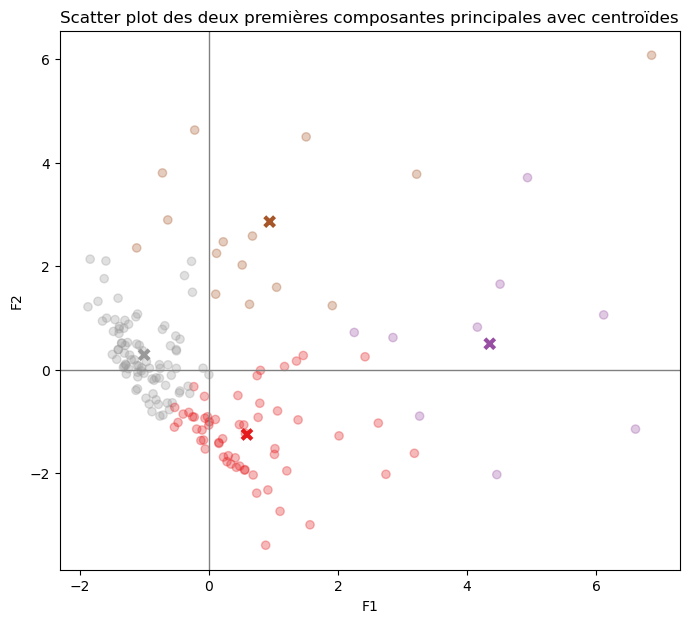

In [1290]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

# Affichage du scatter plot des deux premières composantes principales
plt.scatter(X_proj[:,0], X_proj[:,1], c=k2label, cmap="Set1",alpha=0.3)

# Affichage des centroïdes des clusters

plt.scatter(centroids_proj.iloc[:,0], centroids_proj.iloc[:,1],c=range(len(centroids_proj)),cmap="Set1", marker='x', s=50, linewidths=3)

# Ajout de labels pour les axes et un titre
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Scatter plot des deux premières composantes principales avec centroïdes')
# Add gray lines at the origin
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)

plt.show()

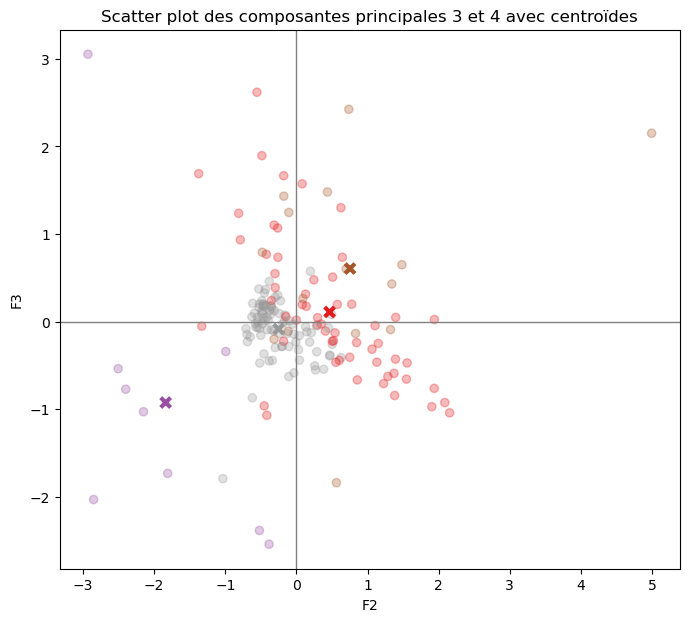

In [1291]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

# Affichage du scatter plot des composantes principales 3 et 4
plt.scatter(X_proj[:,2], X_proj[:,3], c=k2label, cmap="Set1",alpha=0.3)

# Affichage des centroïdes des clusters

plt.scatter(centroids_proj.iloc[:,2], centroids_proj.iloc[:,3],c=range(len(centroids_proj)),cmap="Set1", marker='x', s=50, linewidths=3)

# Ajout de labels pour les axes et un titre
plt.xlabel('F2')
plt.ylabel('F3')
plt.title('Scatter plot des composantes principales 3 et 4 avec centroïdes')
# Add gray lines at the origin
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)

plt.show()

# 3D

## Grahique en 3 Dimensions, projections sur les 3 composantes principales

In [1292]:
fig = px.scatter_3d(x=X_proj[:,0], y=X_proj[:,1], z=X_proj[:, 2],
              color=k2label)


fig.show()

# FIN